In [366]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
!pip install contractions rich spacy wordcloud opencv-python

In [2]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds


# Analíse de reviews de videogames da Amazon

[dataset original](https://jmcauley.ucsd.edu/data/amazon/)

## Referencias
- [NLTK Book Online](http://www.nltk.org/book/)

* __Turing Talks__
    - [Introdução a NLTK com Dom Casmurro](https://medium.com/turing-talks/uma-an%C3%A1lise-de-dom-casmurro-com-nltk-343d72dd47a7)
    - [Introdução ao Processamento de Linguagem Natural com Baco Exu do Blues
](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-ao-processamento-de-linguagem-natural-com-baco-exu-do-blues-17cbb7404258)
    - [Introdução a Bag of Words e TF-IDF](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)
        - [notebook](https://github.com/turing-usp/BoW-e-TFIDF/blob/master/BoW_e_TFIDF.ipynb)
    - [Sua primeira análise de sentimentos com scikit-learn](https://medium.com/turing-talks/sua-primeira-an%C3%A1lise-de-sentimentos-com-scikit-learn-a47c088ea7bd)
        - [notebook com outros modelos](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos)
    - [Como Avaliar Seu Modelo de Classificação](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e)
    - [Modelos de Predição: Regressão Logística](https://medium.com/turing-talks/turing-talks-14-modelo-de-predi%C3%A7%C3%A3o-regress%C3%A3o-log%C3%ADstica-7b70a9098e43)
    - [Modelos de Predição: SVM](https://medium.com/turing-talks/turing-talks-12-classifica%C3%A7%C3%A3o-por-svm-f4598094a3f1)
    - [Modelos de Predição: Otimização de Hiperparâmetros em Python](https://medium.com/turing-talks/modelos-de-predi%C3%A7%C3%A3o-otimiza%C3%A7%C3%A3o-de-hiperpar%C3%A2metros-em-python-3436fc55016e)
    
    
* __Outros artigos__
    - [Tune Hyperparameters for Classification Machine Learning Algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)
    - [Ajuste de hiperparâmetros da máquina de vetores de suporte usando GridSearchCV](https://ichi.pro/pt/ajuste-de-hiperparametros-da-maquina-de-vetores-de-suporte-usando-gridsearchcv-84762909548242)
    - [Validação Cruzada: Aprenda de forma simples como usar essa técnica](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/)

* __Videos__
    - [Hiperparâmetros, conjunto de validação e sobreajuste (overfitting)](https://www.youtube.com/watch?v=wWBWxtw05p0)
    - [Train/Dev/Test Set Distributions (C3W1L05)](https://www.youtube.com/watch?v=M3qpIzy4MQk&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b)

In [1]:
from rich import print 
from rich.console import Console
from IPython.display import display, Markdown

console = Console()

In [2]:
import pandas as pd
import numpy as np
import itertools
#from pandas_profiling import ProfileReport

In [3]:
from ast import literal_eval # para representar a str '[]' como lista []
import contractions # expandir contracoes
import string # tratamentos de str
import re # remover pontucao
import unicodedata # normalizar strings

In [ ]:
!python -m spacy download en_core_web_sm

In [4]:
import spacy

In [7]:
nltk.download('stopwords')

In [ ]:
nltk.download('wordnet')

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [5]:
import nltk
from nltk.corpus import stopwords # remover stopwords
from nltk import WordNetLemmatizer # lemantizador
from nltk.probability import FreqDist # grafico com frequencia de palavras no texto
from nltk import word_tokenize, sent_tokenize # tokenizaçao
from nltk.tokenize import TweetTokenizer # tokenizaçao considerando tbm emojis e internetes
from nltk.tokenize.casual import EMOTICON_RE # remover emojis

In [341]:
# Features:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # TF-IDF e BoW

# Validacao:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV,  train_test_split

# Modelos:
from sklearn.ensemble import RandomForestClassifier # florestas aleatorias
from sklearn.linear_model import LogisticRegression # regressao logistica
from sklearn.tree import DecisionTreeClassifier # arvore de decisao
from sklearn.naive_bayes import MultinomialNB # naive bayes
from sklearn.svm import SVC # suport vector machine

# Metricas:
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score

# Criar pipelines para os modelos:
from sklearn.pipeline import Pipeline

In [7]:
from wordcloud import WordCloud
import cv2 as cv # Pra mascara do wordcloud

In [8]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

In [9]:
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : '16'}

mpl.rc('font', **font)

In [10]:
dfReview = pd.read_csv('video_games_reviews_train.csv')

## Pré-processamento e Análise do corpus

### Visualizacao dos dados brutos e limpeza

In [11]:
dfReview.head(10)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"
3,6070,42574,A1DP3YZ2OQWAP4,B0000ARQMW,liz,"[0, 0]",I really like this game i love all the challen...,5,Jammin banging game,1383436800,"11 3, 2013"
4,11616,172598,A48Z207T98FN0,B004HYK8Y8,The Reverend,"[296, 368]",*** please read the 12/9/11 update below this ...,1,Consumers are NOT Beta-Testers !!! (updated),1322784000,"12 2, 2011"
5,9852,214525,A0815906MFVDTIFHGRQR,B00ATF5YY8,Diego B.,"[0, 0]","At the beginning I though, &#34;Wow! this game...",3,"Ok game, kinda bad story.",1374796800,"07 26, 2013"
6,11832,62284,A1OJXGNKA0QGUW,B000B6OBPS,J. Woods,"[1, 2]","Honestly I think this is pretty bad, and let m...",1,Don't believe the hype..,1333670400,"04 6, 2012"
7,838,80635,A2SP52NH44LRDS,B000MUW98O,Happy r/c,"[0, 3]",Try GRID racing game which I think is better.W...,2,Motorcycle doing wheelie can't flip backwards,1268956800,"03 19, 2010"
8,7485,167288,A1BBYSMT9YCODI,B0045EI7I4,korova,"[60, 67]",Long time fans of Grand Theft Auto know that e...,4,Rockstar's Rashomon,1288569600,"11 1, 2010"
9,2635,207739,A2TIP4NEY64PLK,B008DNUXA8,"Fun Times Mom ""Hayley""","[7, 9]",For the few minutes that my son played he had ...,1,RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...,1355097600,"12 10, 2012"


In [12]:
dfReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         8000 non-null   int64 
 1   index           8000 non-null   int64 
 2   reviewerID      8000 non-null   object
 3   asin            8000 non-null   object
 4   reviewerName    7916 non-null   object
 5   helpful         8000 non-null   object
 6   reviewText      7999 non-null   object
 7   overall         8000 non-null   int64 
 8   summary         8000 non-null   object
 9   unixReviewTime  8000 non-null   int64 
 10  reviewTime      8000 non-null   object
dtypes: int64(4), object(7)
memory usage: 687.6+ KB


* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

Pra analises preliminares acredito que a maioria das colunas sao relevantes, com excessao de level_0, index, reviewTime (Por ser uma redundância de unixReviewTime) e reviewerName (Por ser uma redundância do reviewerID)

<span style="background-color: #ffa07a">As colunas de interesse para o modelo sao: concatenar(*reviewText* + *summary*) como X e *overall* como y</span>

Portanto esses dados nao podem conter NaN|null|None como valor ou estarem replicados, entao vou comecar por uma limpeza dessas infos

In [13]:
# Colunas com valores NaN
dfReview.isna().sum()

level_0            0
index              0
reviewerID         0
asin               0
reviewerName      84
helpful            0
reviewText         1
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Como só há 1 valor NaN na coluna *reviewText*, ao unir com a a coluna *summary* formar um unico texto, nao vao mais haver NaN, portanto nao é nescessario excluir a respectiva linha

In [14]:
# Unir as colunas reviewText e summary
dfReview['reviewText'] = dfReview.apply(lambda x: x.summary + ' ' + x.reviewText if str(x.reviewText) != 'nan' else x.summary, axis=1)

In [15]:
print("Dados duplicados " + str(len(dfReview[dfReview.duplicated()])))

Dados duplicados 0

In [16]:
print("Sobre os jogos e os avaliadores resumidamente temos:")
print('Numero de reviewerID unicos: ' + str(len(dfReview['reviewerID'].unique())) + '/' +  str(len(dfReview['reviewerID'])))
print('Numero de produtos unicos: ' + str(len(dfReview['asin'].unique())) + '/' +  str(len(dfReview['reviewerID'])))

Sobre os jogos e os avaliadores resumidamente temos:

Numero de reviewerID unicos: 6038/8000

Numero de produtos unicos: 4368/8000

In [17]:
# convertendo reviewTime em datetime:
dfReview['reviewTime'] = pd.to_datetime(dfReview['reviewTime'], format='%m %d, %Y')

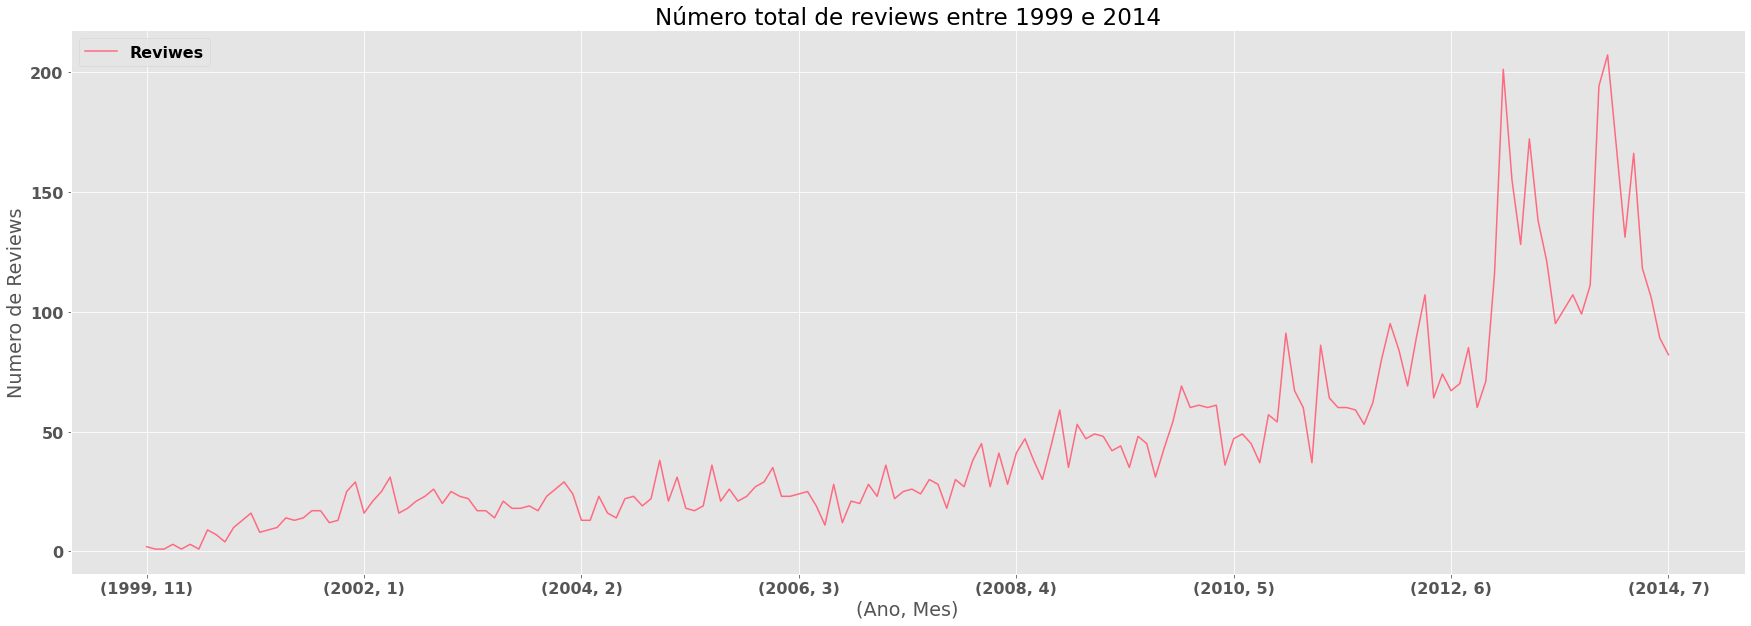

In [18]:
plt.figure(figsize=(30, 10))
p = dfReview.groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#ff6a80', label='Reviwes')
p1 = p.set_xlabel('(Ano, Mes)')
p1 = p.set_ylabel('Numero de Reviews')
p1 = p.set_title('Número total de reviews entre 1999 e 2014')
p1 = p.legend()

Da pra ver uma progressao linear do numero de reviews entre 1999 e 2014, mas não sei a principio o quanto isso é significativo, pode ser por ampliar o acesso a internet e por isso mais comentarios, mas é um palpite, ou ainda, como sao varios jogos avaliados os picos podem ser referentes ao jogo, ou mesmo combinacao desses e outros fatores. Em relacao a sazonalidade mensal não vejo nenhum padrao claro, vou ver como fica fazendo o hue entre avaliacoes positivas e negativas ao longo do tempo

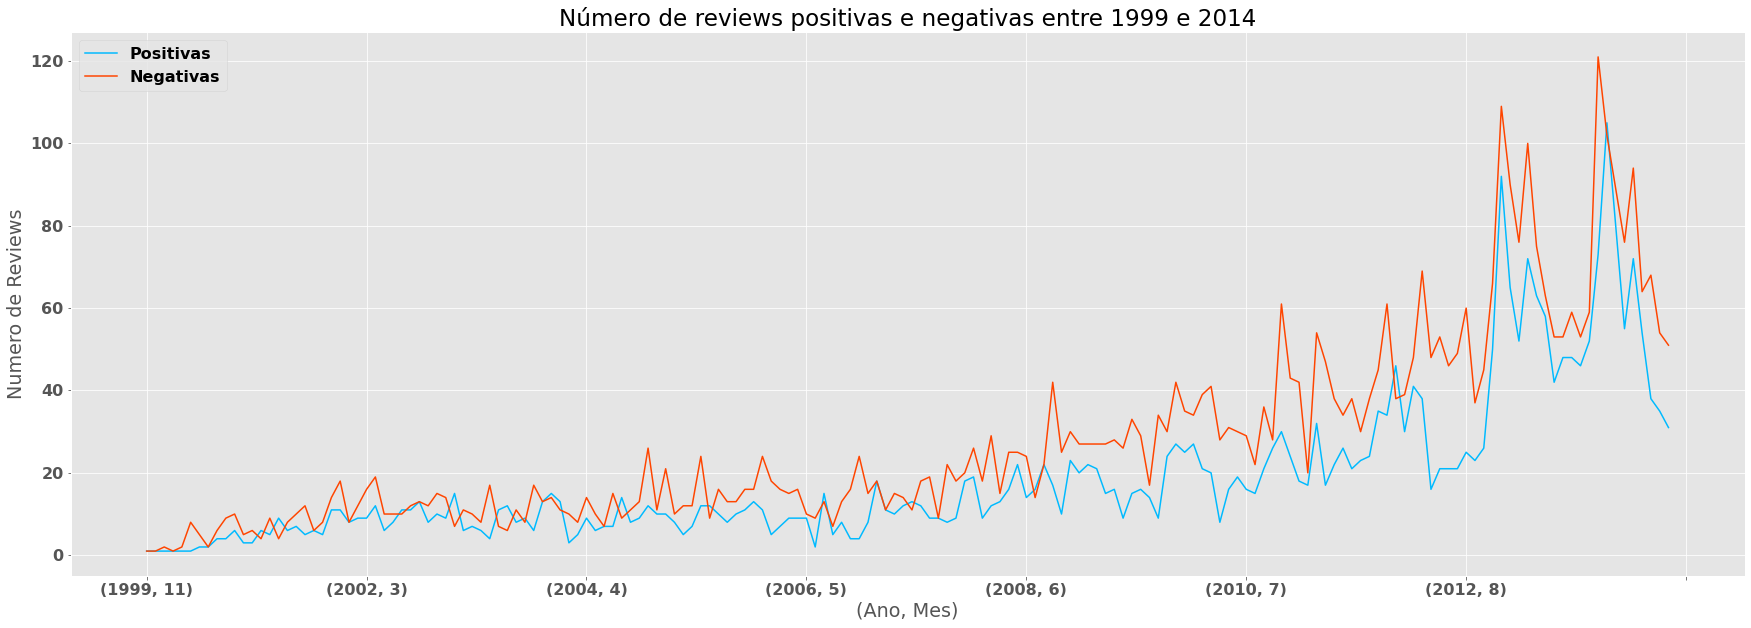

In [19]:
plt.figure(figsize=(30, 10))
p = dfReview[dfReview['overall'] > 3].groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#00baff', label='Positivas')
p1 = dfReview[dfReview['overall'] <= 3].groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#ff4500', ax=p, label='Negativas')
p1 = p.set_xlabel('(Ano, Mes)')
p1 = p.set_ylabel('Numero de Reviews')
p1 = p.set_title('Número de reviews positivas e negativas entre 1999 e 2014')
p1 = p.legend()

Interessante muitos picos coincidirem, mas ao longo de tempo vemos tambem que o numero de reviews negativas permanece maior, vou acrescentar um pequeno filtro nisso: jogos que tenham mais que duas reviews, pois é natural se for algo que realmente nao goste, por questoes possoais, ou que tenha problema com a compra (atraso, produto errado, etc) que a pessoa deixe um comentario pontual, mas filtrando por jogos com mais que um comentario, filtramos esse viés, ou minimizamos pelo menos

In [20]:
gamesMoreOne = dfReview.groupby('asin').count()[dfReview.groupby('asin').count()['reviewText'] > 2].index
console.print(f"{len(gamesMoreOne)} de {len(dfReview['asin'].value_counts())} jogos possuem mais que duas avaliacoes", style="bold", highlight=False)

768 de 4368 jogos possuem mais que duas avaliacoes

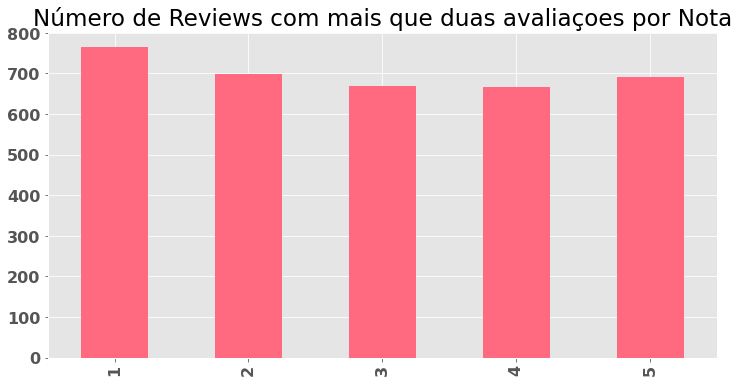

In [21]:
plt.figure(figsize=(12, 6))
p = dfReview[dfReview['asin'].isin(gamesMoreOne)]['overall'].value_counts().sort_index().plot(kind='bar', color='#ff6a80')
p1 = p.set_title('Número de Reviews com mais que duas avaliaçoes por Nota')

É, o numero de reviews negativas realmente é maior ... 

Quanto a coluna *helpful* a principio vou separar em duas novas colunas *helpful_pos* e *helpful_neg*, ou seja separar em quantos consideraram a review positiva e quantos consideram negativas

In [22]:
dfReview['helpful_pos'] = dfReview['helpful'].apply(lambda x:literal_eval(x)[0])
dfReview['helpful_neg'] = dfReview['helpful'].apply(lambda x:literal_eval(x)[1]-literal_eval(x)[0])

In [23]:
dfReview[dfReview['helpful_neg'] > 1].groupby('overall').sum().reset_index()

,overall,level_0,index,unixReviewTime,helpful_pos,helpful_neg
0,1,6653153,130596376,1373721465600,13574,22567
1,2,5154073,89849915,1009518854400,7661,6162
2,3,3326439,58885631,639501177600,3834,2833
3,4,1959341,32551131,365125708800,3380,1160
4,5,1837445,31375924,329283878400,4474,1432


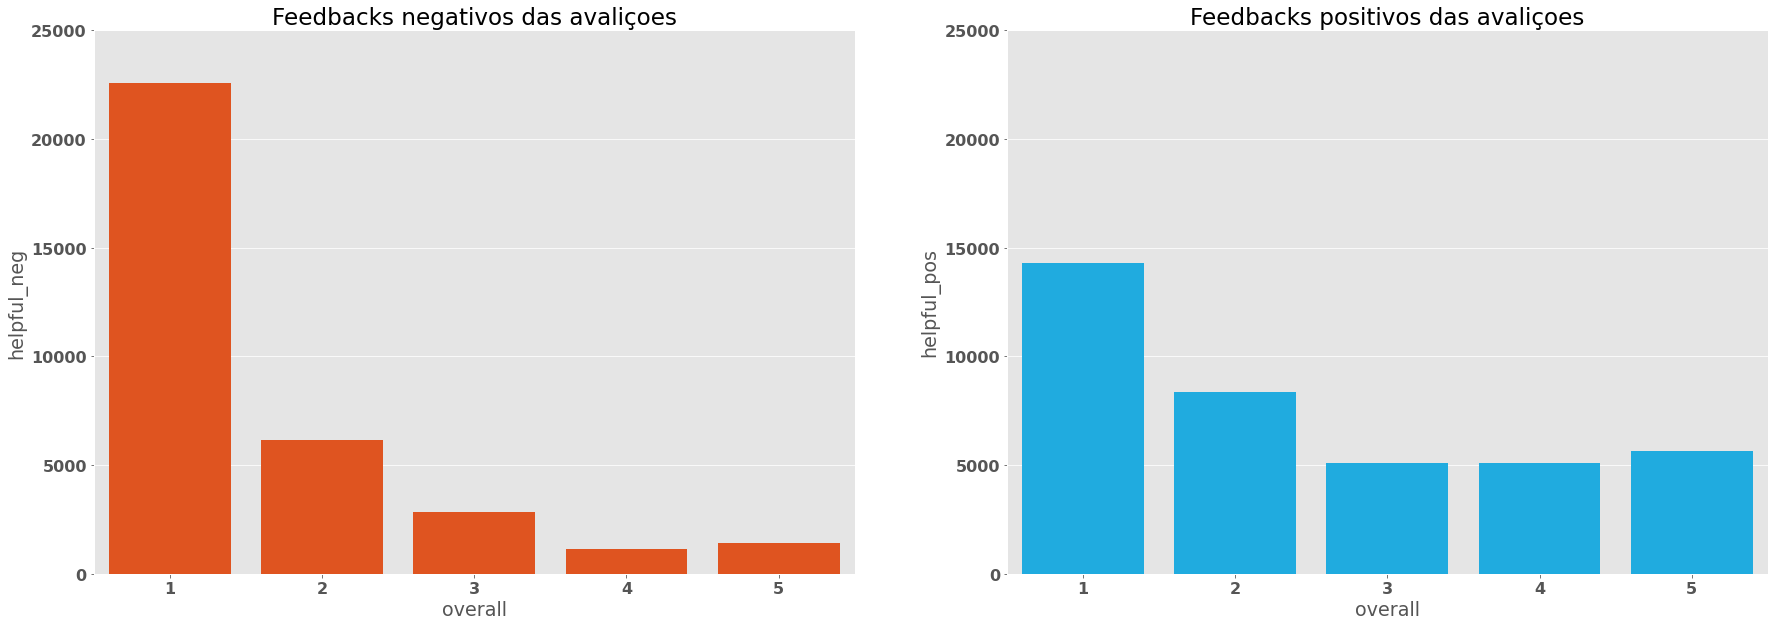

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

p = sns.barplot(data=dfReview[dfReview['helpful_neg'] > 1].groupby('overall').sum().reset_index(), 
                y='helpful_neg', 
                x='overall', color='#ff4500', ax=ax[0])

p = sns.barplot(data=dfReview[dfReview['helpful_pos'] > 1].groupby('overall').sum().reset_index(), 
                y='helpful_pos', 
                x='overall', color='#00baff', ax=ax[1])

p = ax[0].set_title('Feedbacks negativos das avaliçoes')
p = ax[1].set_title('Feedbacks positivos das avaliçoes')

p = ax[0].set_ylim(0, 25000)
p = ax[1].set_ylim(0, 25000)

Interessate, varias avaliaçoes negativas (com nota 1) receberam um feedback negativo, talvez por serem comentarios rispidos ou apenas por nao agregarem nada, como só um *Não gostei*

In [25]:
dfReview[(dfReview['overall'] == 1) & (dfReview['helpful_neg'] > dfReview['helpful_pos'])][['asin', 'reviewText']]

,asin,reviewText
0,B00CX6XKK6,wasted 500 dollars on the xbox one. ive got to...
11,B000B43OY4,Come on people! This is idiotic selling a syst...
22,B0000683EW,Very Disappointing This is the most dissapoint...
25,B000FRS9II,"don't like it I don't like the graphics, so mu..."
29,B0050SYX8W,nothing new to see here. I'll start out by say...
...,...,...
7948,B00005KBRD,This is soooo DULL! I would like to write more...
7953,B00CX9L30W,#boring going back to Rift. :( No content! Go...
7978,B0025KZV7U,bad i don't play a lot of video games but i've...
7990,B0047TLIBU,Don't Buy. Super Glitchy. Load Screens NEVER A...


Realmente ... alguns bem rispidos!

Procurei alguns desses jogos na [Amazon](https://www.amazon.com) atravez do ID (*asin*):


**B0000683EW:**
<img src="https://images-na.ssl-images-amazon.com/images/I/51HFPSGCNML.jpg" width="200" align="center">
**B000FRS9II:**
<img src="https://images-na.ssl-images-amazon.com/images/I/51cKx1N2jRL.jpg" width="200" align="center">
**B0047TLIBU:**
<img src="https://images-na.ssl-images-amazon.com/images/I/71d7GhTLvLL._SL1005_.jpg" width="200" align="center">

Eles possuem uma media de avaliaçao boa, quase 5 estrelas, talvez por isso os comentarios negativos estao mal avaliados, mas claro levando em conta que eu peguei 3 amostras em 793 reviews

Como especificado no enunciado, deve-se fazer uma classificacao binaria, **0 para avaliacao menor ou igual a 3 e 1 para maiores**, estao crio uma nova coluna binaria em funcao da *overall* mas nao faço o drop a original para algumas analises

In [26]:
# criar coluna binaria do overall 1 if nota > 3 else 0
dfReview['overallBinary'] = dfReview['overall'].apply(lambda x: 1 if x > 3 else 0)

In [27]:
neg = len(dfReview[dfReview['overallBinary'] == 0])
pos = len(dfReview[dfReview['overallBinary'] == 1])
console.print('Numeros de reviews de acordo com a polaridade: ', style="bold")
console.print('Reviews positivas: '+str(pos), style="bold #00cd37", highlight=False)
console.print('Reviews negativas: '+str(neg), style="bold #e63e00", highlight=False)

Numeros de reviews de acordo com a polaridade: 

Reviews positivas: 3238

Reviews negativas: 4762

Confirmando o grafico em função do tempo mostrando um número maior de reviews negativas.

Vou criar tambem uma coluna com o tamanho das reviws pre pre-processamento pra comparar a reducao apos remover stopwords, pontuacao, etc.

In [28]:
dfReview['lenReviewBruto'] = dfReview['reviewText'].apply(len)

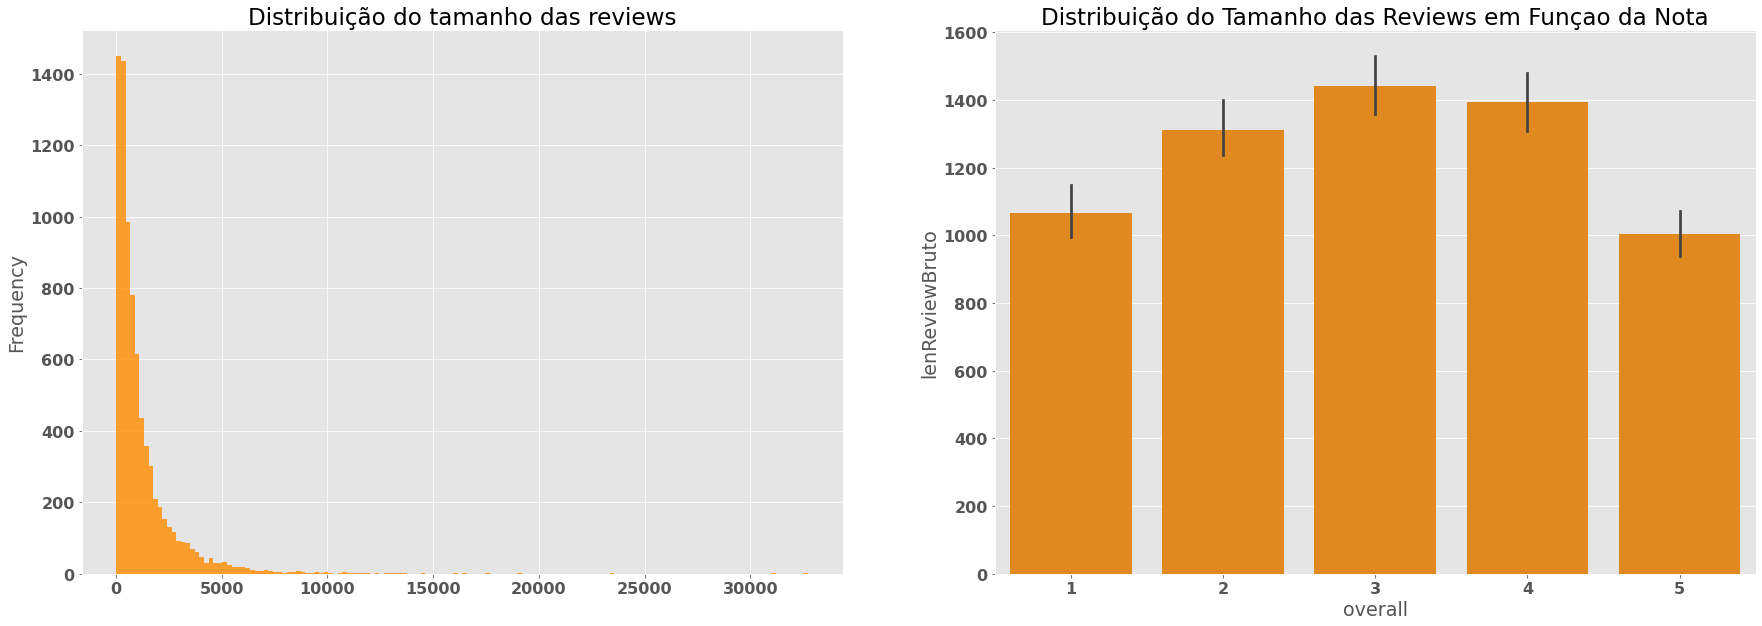

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
p = dfReview['lenReviewBruto'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='#ff8c00', label='words')
p = sns.barplot(data=dfReview, x='overall', y='lenReviewBruto', color='#ff8c00', ax=ax[1])
p1 = ax[0].set_title('Distribuição do tamanho das reviews')
p1 = ax[1].set_title('Distribuição do Tamanho das Reviews em Funçao da Nota')

Em relaçao a quantidade de caracteres nao parece haver correlacao direta a nota, apenas outliers discrepantes, mas a distribuicao dos dados é parececida, com volume um pouco maior para 3 e 4, parece uma distribuicao normal

In [30]:
#df = dfReview.sort_values(by='lenReviewBruto', ascending=False).reset_index()
#df["cumpercentage"] = df["lenReviewBruto"].cumsum()/df["lenReviewBruto"].sum()*100
#
#fig, ax = plt.subplots(figsize=(30, 10))
#ax.bar(df.index, df["lenReviewBruto"], color="#ffa500")
#ax2 = ax.twinx()
#ax2.plot(df.index, df["cumpercentage"], color="#005aff")
#ax2.yaxis.set_major_formatter(PercentFormatter())
#p = ax.set_title('Distribuiçao de Pareto')

In [31]:
# removendo colunas desnecessarias:
dfReview.drop(['level_0', 'index', 'unixReviewTime', 
               'reviewerName', "summary", "helpful"], axis=1, inplace=True)

In [32]:
console.print('Dataset limpo:', style="bold #00a8e6")
#ProfileReport(dfReview.head(10))
dfReview.head(10)

Dataset limpo:

,reviewerID,asin,reviewText,overall,reviewTime,helpful_pos,helpful_neg,overallBinary,lenReviewBruto
0,A1U1AK7HKB2BLN,B00CX6XKK6,wasted 500 dollars on the xbox one. ive got to...,1,2013-11-22,4,47,0,195
1,A1L1D50VH2AX7J,B0017UFWMS,Margots Word Brain This game gives you a serie...,2,2011-11-21,0,0,0,249
2,A2JWU211CM0BYE,B00005RCR0,"Excellent product, watch the discs You should ...",4,2013-02-11,0,1,1,238
3,A1DP3YZ2OQWAP4,B0000ARQMW,Jammin banging game I really like this game i ...,5,2013-11-03,0,0,1,199
4,A48Z207T98FN0,B004HYK8Y8,Consumers are NOT Beta-Testers !!! (updated) *...,1,2011-12-02,296,72,0,5959
5,A0815906MFVDTIFHGRQR,B00ATF5YY8,"Ok game, kinda bad story. At the beginning I t...",3,2013-07-26,0,0,0,845
6,A1OJXGNKA0QGUW,B000B6OBPS,Don't believe the hype.. Honestly I think this...,1,2012-04-06,1,1,0,1029
7,A2SP52NH44LRDS,B000MUW98O,Motorcycle doing wheelie can't flip backwards ...,2,2010-03-19,0,3,0,351
8,A1BBYSMT9YCODI,B0045EI7I4,Rockstar's Rashomon Long time fans of Grand Th...,4,2010-11-01,60,7,1,3134
9,A2TIP4NEY64PLK,B008DNUXA8,RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...,1,2012-12-10,7,2,0,1063


### Pré-Processamento

#### Verificando pontuação e emojis

In [33]:
dfReview['exclamacao'] = dfReview['reviewText'].apply(lambda x:int(x.count('!')))
dfReview['interrogacao'] = dfReview['reviewText'].apply(lambda x:int(x.count('?')))
dfReview['emojis'] = dfReview['reviewText'].apply(lambda x:len(EMOTICON_RE.findall(x)))

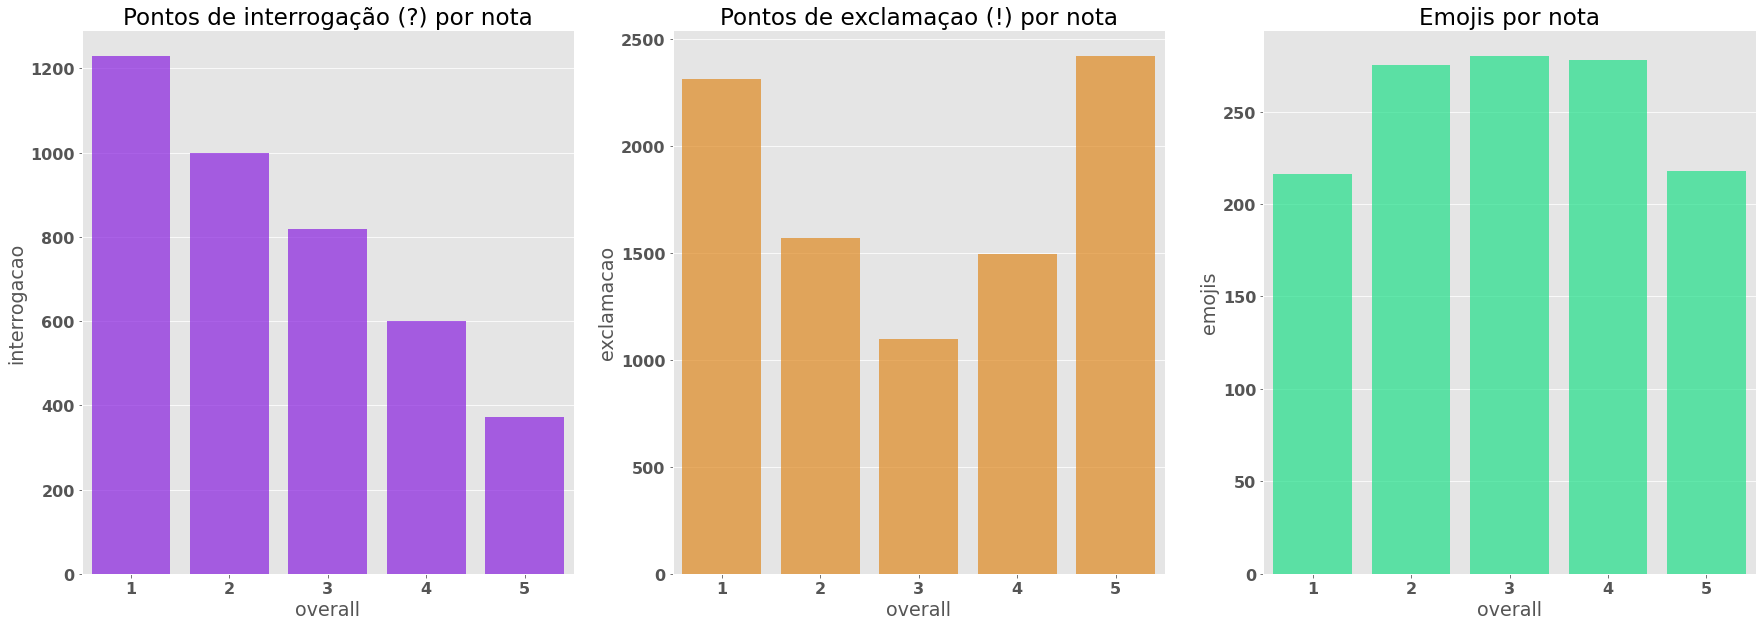

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))


p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='interrogacao', ax=ax[0], color='#8c00ff', alpha=.7)
p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='exclamacao', ax=ax[1], color='#ff8c00', alpha=.7)
p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='emojis', ax=ax[2], color='#00ff8c', alpha=.7)

p = ax[0].set_title('Pontos de interrogação (?) por nota')
p = ax[1].set_title('Pontos de exclamaçao (!) por nota')
p = ax[2].set_title('Emojis por nota')

Em relação aos emojis, pra decidir como vao ser tratados, vou ver como fica a distribuiçao deles nas reviews, criando uma lista de emojis de reviews negativas (<= 3) e positivas (>3) e depois vendo quais elementos sao unicos nessas listas, ou seja quais sao significativos para expressar a polaridade da respectiva review

Sobre a pontucao acho que seria interessante adicionar (?) ao texto de alguma forma, mas não encontrei nenhuma maneira de fazer isso de maneira que agregue ao texto :-/

In [35]:
goodReviwes = ' '.join(dfReview[dfReview['overallBinary'] == 1]['reviewText'])
badReviwes = ' '.join(dfReview[dfReview['overallBinary'] == 0]['reviewText'])

goodEmojis = EMOTICON_RE.findall(goodReviwes)
goodEmojis = list(set(goodEmojis))
badEmojis = EMOTICON_RE.findall(badReviwes)
badEmojis = list(set(badEmojis))

badUnique = [i for i in badEmojis if i not in goodEmojis]
goodUnique = [i for i in goodEmojis if i not in badEmojis]

In [36]:
console.print(f'Emojis em reviews negativas ({len(badEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(badEmojis), style="bold #ff4500", highlight=False)

console.print(f'\n\nEmojis em reviews positivas ({len(goodEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(goodEmojis), style="bold #00baff", highlight=False)

console.print(f'\n\nEmojis unicos em reviews negativas ({len(badUnique)}/{len(badEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(badUnique), style="bold #ff4500", highlight=False)

console.print(f'\n\nEmojis unicos em reviews positivas ({len(goodUnique)}/{len(goodEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(goodUnique), style="bold #00baff", highlight=False)
#ffc500

Emojis em reviews negativas (59): 

(=   :-P   =D   (8   P;   :\   /8   ;D   p:   :-[   ]:   );   :)   ;:   |8   ;)   >:(   )=   
;-)   D:   8(   8:   8p   :=   ;d   d=   :[   :(   8/   do:   d;   :-p   :/   :P   =/   :O)  
P:   p;   /'8   ;/   PO:   ;p   :o)   P8   :D   d:   do;   ;P   =(   D=   :-)   =P   =)   ;op
:-(   8)   d:>   ):   D;

Emojis em reviews positivas (55): 

(8   =D   )8   :\   /8   ;D   p:   ]:   );   D8   =*[   :)   =]   D;   ;OP   ;:   :-]   :8   
;)   ;-)   D:   8(   ;d   =p   d=   =[   :[   d8   8-d   :(   8/   do:   d;   :/   :P   =/   
P:   p;   8Op   (:   ;p   P8   :D   ::   d:   ;P   =(   :-)   :Op   =P   =)   :-(   8)   ):  
P=

Emojis unicos em reviews negativas (20/59): 

(=   :-P   P;   :-[   |8   >:(   )=   8:   8p   :=   :-p   :O)   /'8   ;/   PO:   :o)   do;  
D=   ;op   d:>

Emojis unicos em reviews positivas (16/55): 

)8   D8   =*[   =]   ;OP   :-]   :8   =p   =[   d8   8-d   8Op   (:   ::   :Op   P=

<span style="background-color: #ffbf00">Por mais que hajam relativamente muitos emojis aparentemente eles nao agregam muito ao resultado da polaridade pois ha muitos emojis do tipo :-) em reviews negativas e :-( em positivas e numero unico por polaridade é bem baixo em proporção, entao eu vou remove-los junto com as stopwords</span>(tratadas a seguir)

#### Remocao de stopwords

A principio, estou usando a lista de stopwords da biblioteca nltk, que contem as seguintes palavras: 

In [37]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Mas fazendo apenas isso uma primeira vez obtive o seguinte: 

<span style="background-color: #ffa07a">Frequencia das palavras no geral: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq.jpg)

<span style="background-color: #ffa07a">Frequencia das palavras em reviews positivas: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq_pos.png)

<span style="background-color: #ffa07a">Frequencia das palavras em reviews negativas: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq_neg.png)

Há muitas palavras que aparentemente nao agragam muito a polaridade da review no contexto compra de jogos e nao estao na lista de nltk, como: **game**, **buy** e **play** e outras que se repetem muito, sem ter relacao direta com o contexto, mas tambem não parecem agregar muito, como: **like**, **get** e **one**

E a concordancia e pavras similares a elas eram:

In [38]:
with open('imagens/concordancias_similaridades.txt', 'r') as textfile:
    print(textfile.read())

Concordancia para palavra play: 
Displaying 25 of 10848 matches:
waste dollars xbox one get play console honestly say look x better p
ccasional game simply miss boat come play fun excellent product watch discs pr
ay bethesdas payroll would like able play game instead feel like get rob lie u
econd time row hoop ask players jump play mess balance basketball nose play he
mp play mess balance basketball nose play help end update ok game kind bad sto
o change parametershowever opponents play way matter even change strength hand
nd total opposites default opponents play way think change anything effecti te
opponent full table various settings play hours still play play alter themit o
le various settings play hours still play play alter themit ok simulator play 
rious settings play hours still play play alter themit ok simulator play somew
 play play alter themit ok simulator play somewhat competent opponents style t
tion whether gta iv two episodes fun play answer yes even though clear rocksta
e price set big deal important thing play series order release gta iv tlad tbo
keep year olds attention minutes son play jump around maze platforms kill bug 
me kill bug jump around figure maybe play minutes topsand want buy game thank 
buy game read review get game excite play replay quickly subside get think bac
partcroft manor back see change love play section nice little distractionwith 
ay level remove force start new game play againthe bonoculars although cool us
lax game need take seriously already play game think already play game back ca
usly already play game think already play game back call call duty stop play o
y play game back call call duty stop play overwhelm sense know war suppose cha
ntertain get thru cod desire go back play yet play game different name slight 
get thru cod desire go back play yet play game different name slight change sc
k xiii control like console fps game play socom red faction timesplitters fami
 old kid wrong p bore think remember play first come playstation think remembe

Palavras similares a play: 
game get like make one buy fun good great go really first time think
say would look use see even



Concordancia para palavra like: 
Displaying 25 of 8977 matches:
stroy errors jammin bang game really like game love challenge love different p
e charge pay bethesdas payroll would like able play game instead feel like get
uld like able play game instead feel like get rob lie update patch issue repor
bad story begin though wow game look like really cool timeline split story sto
remise game completely awesome least like time travel stuff however narrative 
ke much expensive mistake still sort like would bet one come price rather quic
ven enjoy slower pace game sometimes like deblob game near captivate buy donke
 game near captivate buy donkey kong like jump around squash things much bette
little distractionwith onto badwhile like croft manor inability replay level r
level begin show terrible werei felt like game nothing assault course lara go 
r insult injury level far short come like explore every nook cranny every leve
e first conquer puzzle get main boss like anniversarylara look great wear fall
sult injury show cleavage doube uggh like women much beutiful woman dress like
like women much beutiful woman dress like esepcially archeologist hate despise
i game within main gamethe one thing like game move forward onto different pla
g graphical technique make game look like cartoon level detail throughout amaz
el detail throughout amaze look feel like comic book xiii control like console
ok feel like comic book xiii control like console fps game play socom red fact
rsion exclusive multiplayer mode fun like deathmatch kill certain players xbox
nce pay may keep sexappeal also lack like slutty teenager game try hard get ex
irst come playstation think remember like somewhatbut boy wrong change quite l
on perspective work well shootthemup like graphics game concept control paramo
eview k cut many options play online li

Ja existem outras palavras similares que nao parecem muito, <span style="background-color: #ffbf00">entao decidi tirar essa primeras palavras junto com as stopwords com execassao do like por ser uma polissemia e rodar o pre-processamento novamente</span>. Mesmo havendo mais palavras assim acho que nao seria interessante remover todas pois acredito que possa causar um overfitting do modelo

In [39]:
# texto = nltk.Text(' '.join(list(dfReview['reviewTextPreProc'])).split())

# console.print('Concordancia para palavra play: ', style="bold", highlight=False)
# display(Markdown(texto.concordance('play')))
# console.print('Palavras similares a play: ', style="bold", highlight=False)
# texto.similar('play')

# console.print('\n\n\n\nConcordancia para palavra like: ', style="bold", highlight=False)
# print(texto.concordance('like'))
# console.print('Palavras similares a like: ', style="bold", highlight=False)
# texto.similar('like')

# console.print('\n\n\n\nConcordancia para palavra one: ', style="bold", highlight=False)
# print(texto.concordance('one'))
# console.print('Palavras similares a one: ', style="bold", highlight=False)
# texto.similar('one')

# console.print('\n\n\n\nConcordancia para palavra time: ', style="bold", highlight=False)
# print(texto.concordance('time'))
# console.print('Palavras similares a time: ', style="bold", highlight=False)
# texto.similar('time')

# console.print('\n\n\n\nConcordancia para palavra buy: ', style="bold", highlight=False)
# print(texto.concordance('buy'))
# console.print('Palavras similares a buy: ', style="bold", highlight=False)
# texto.similar('buy')

# console.print('\n\n\n\nConcordancia para palavra get: ', style="bold", highlight=False)
# print(texto.concordance('get'))
# console.print('Palavras similares a get: ', style="bold", highlight=False)
# texto.similar('get')

# console.print('\n\n\n\nConcordancia para palavra game: ', style="bold", highlight=False)
# print(texto.concordance('game'))
# console.print('Palavras similares a game: ', style="bold", highlight=False)
# texto.similar('game')

In [40]:
def Preprocessamento(texto):
    texto = texto.lower()
    
    # remocao de contracoes
    texto = contractions.fix(texto)
    
    texto = texto.lower()
    
    # remocao de pontuacao
    pontuacao = re.compile('|'.join(map(re.escape, string.punctuation+'1234567890')))
    texto = pontuacao.sub("", texto)
    
    # vetorizacao
    tk = TweetTokenizer()
    texto = tk.tokenize(texto)
    
    # normalizar
    for i, palavra in enumerate(texto):
        texto[i] = unicodedata.normalize('NFKD', palavra).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remocao de stopwords
    cleanTexto = []
    StopWords = stopwords.words('english')
    
    for palavra in texto:
        if palavra not in StopWords: cleanTexto.append(palavra)
        else: pass
        
        
    # lemmantizacao
    lemmantizador = nltk.WordNetLemmatizer()
    tokentxt =  [lemmantizador.lemmatize(palavra, pos='v') for palavra in cleanTexto]
    
    # remocao de de outras palavras
    cleanTexto = []
    StopWords = []
    
    StopWords.append('game')
    StopWords.append('play')
    StopWords.append('one')
    StopWords.append('get')
    StopWords.append('make')
    StopWords.append('buy')
    StopWords.append('time')
    StopWords.append('character')
    
    for palavra in tokentxt:
        if palavra not in StopWords: cleanTexto.append(palavra)
        else: pass
        
    # removendo verbos
    #tokentxt = nltk.pos_tag(cleanTexto)
    #texto = []
    #for i, palavra in enumerate(tokentxt):
    #    if palavra[1] not in  ['VB', 'PRP']:
    #       texto.append(palavra[0])
        
    return ' '.join(cleanTexto)

In [41]:
%%time
dfReview['reviewTextPreProc'] = dfReview['reviewText'].apply(Preprocessamento)

CPU times: user 20.4 s, sys: 158 ms, total: 20.5 s
Wall time: 20.5 s


In [42]:
print('[bold #ffa64d]Antes do Preprocessamento():[/bold #ffa64d]')
print()
display(dfReview['reviewText'].loc[0])
print()
display(dfReview['reviewText'].loc[1])
print()
display(dfReview['reviewText'].loc[2])
display(dfReview['reviewText'].loc[3])
print()
display(dfReview['reviewText'].loc[4])
print()
print('\n\n[bold #ffa64d]Depois do Preprocessamento():[/bold #ffa64d]')
print()
display(dfReview['reviewTextPreProc'].loc[0])
print()
display(dfReview['reviewTextPreProc'].loc[1])
display(dfReview['reviewTextPreProc'].loc[2])
print()
display(dfReview['reviewTextPreProc'].loc[3])
print()
display(dfReview['reviewTextPreProc'].loc[4])

Antes do Preprocessamento():

'wasted 500 dollars on the xbox one. ive got to play this on both consoles now and can honestly say it looks 100000x better on the ps4 maybe the xbox one i have is messed up but ps4 just killed it'

"Margots Word Brain This game gives you a series of word puzzles to figure out .  I bought this because I am a fan of scrabble but this game can't compete.  It's fine for an occasional game but simply misses the boat when it comes to playing for fun."

"Excellent product, watch the discs You should pretty much already know what this game is about if you're reading reviews. If you're buying used, be careful, since gamecube discs are notorious for being riddled with game destroying errors."

'Jammin banging game I really like this game i love all the challenges. I love that it has different places to visit and that it have goals that you have to complete at each place you visit i love it!'

'Consumers are NOT Beta-Testers !!! (updated) *** please read the 12/9/11 update below this article ***PS3 users:Bad news: This is why you may want to file a complaint with the Federal Trade Commission (protecting consumers):A) the game came with game-breaking bugs that prevent users from finishing itB) it was not stated on the retail-box that an internet connection is required to get the game to work properly in the first place (we\'re not talking patches/updates but major, crucial modifications necessary for an even adequately acceptable gameplay experience)C) retailers won\'t give consumers a full refund if they choose to return this defective product (defective due to the publishers negligence)D) Bethesda\'s latest patch (1.2) has done little to improve the issue and has, in fact, in most cases caused even more grief. Scaling down graphics detail (particuarly landscape-fade-in and dynamic lighting effects) to cover up memory leaks is poor programming and a slap in the face for ever

Depois do Preprocessamento():

'waste dollars xbox console honestly say look x better ps maybe xbox mess ps kill'

'margots word brain give series word puzzle figure fan scrabble compete fine occasional simply miss boat come fun'

'excellent product watch discs pretty much already know read review use careful since gamecube discs notorious riddle destroy errors'

'jammin bang really like love challenge love different place visit goals complete place visit love'

'consumers betatesters update please read update article ps usersbad news may want file complaint federal trade commission protect consumersa come gamebreaking bug prevent users finish itb state retailbox internet connection require work properly first place talk patchesupdates major crucial modifications necessary even adequately acceptable gameplay experiencec retailers give consumers full refund choose return defective product defective due publishers negligenced bethesdas latest patch do little improve issue fact case cause even grief scale graphics detail particuarly landscapefadein dynamic light effect cover memory leak poor program slap face every gamer marvel former graphical beauty instal latest patch read thread www bethesdas forum know poorly perform negatively affect ps hardware really unluckye bethesda show enough effort admit address pinpoint fix problems omission minutely detail changelogs recent patch silence part moderators official webpage bethesda representatives reg

In [43]:
#dfReview['reviewTextPreProc'].loc[1]

### Analises

#### Frequencia de palavras

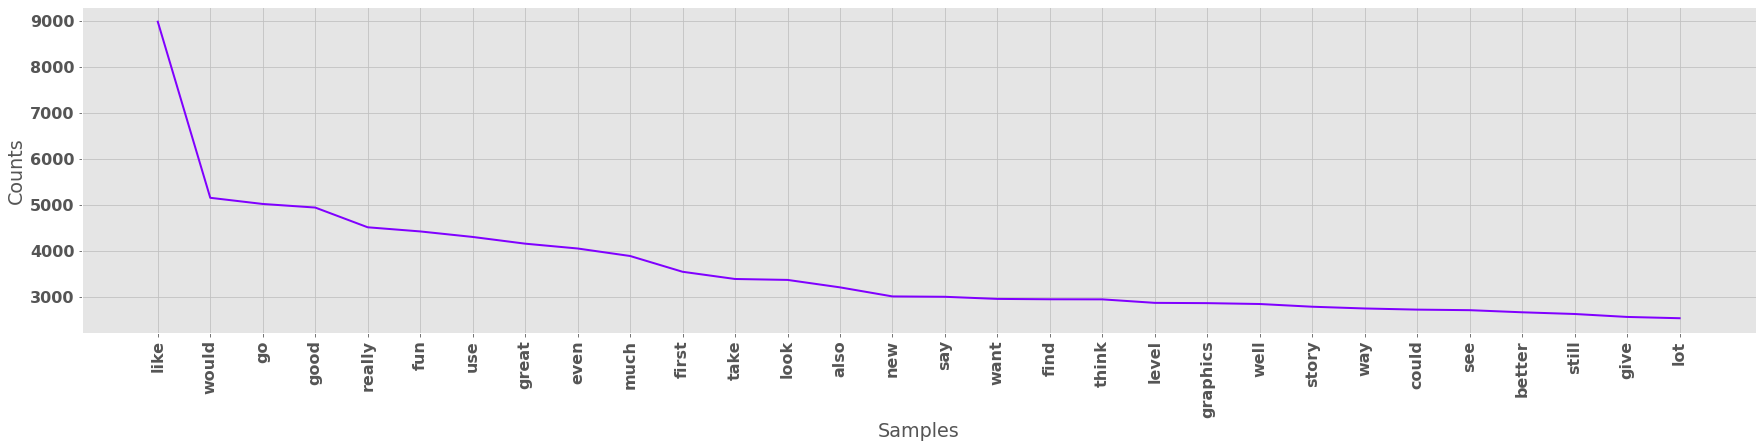

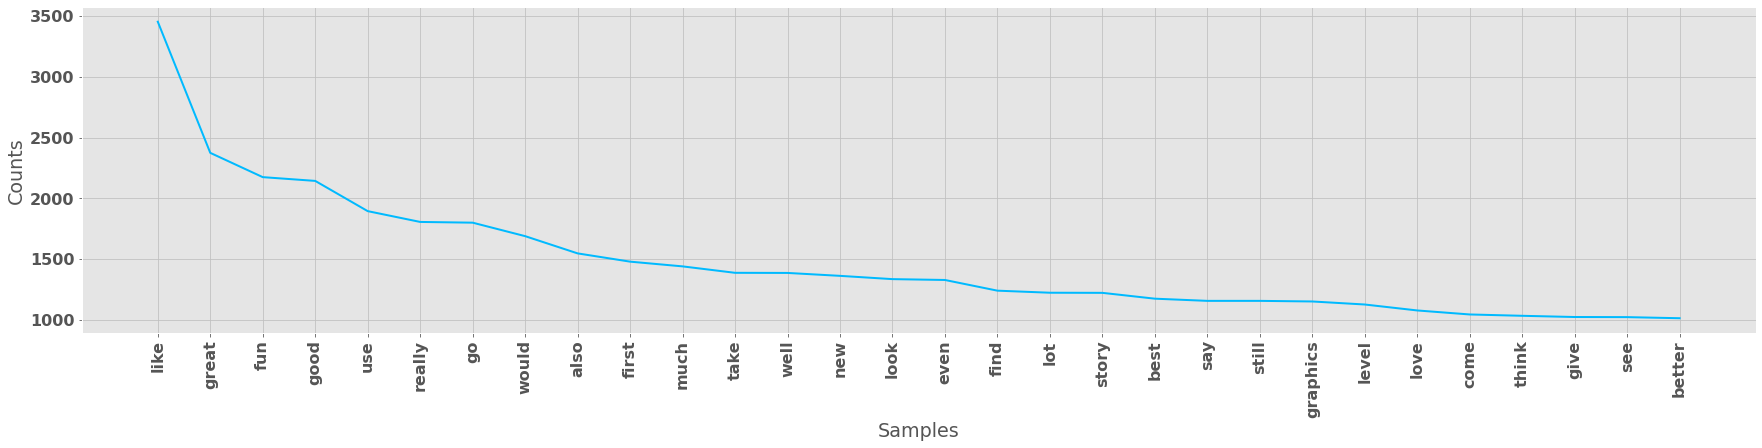

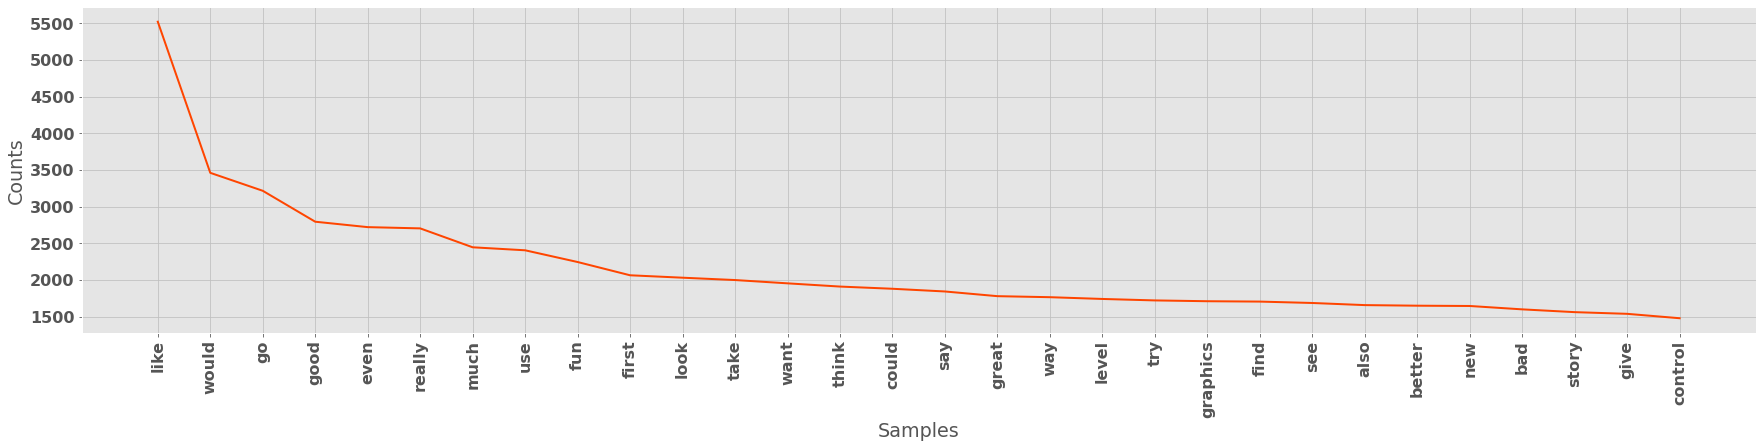

In [44]:
#fig, ax = plt.subplots(3, 1, figsize=(15, 20))

wtk = word_tokenize(' '.join(dfReview['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#8000ff')
#p.set_title('Frequencia de palavras no geral')

wtk = word_tokenize(' '.join(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#00baff')
#p.set_title('Frequencia de palavras em reviews positivas')

wtk = word_tokenize(' '.join(dfReview[dfReview['overallBinary'] == 0]['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#ff4500', )
#p.set_title('Frequencia de palavras em reviews negativas')

In [45]:
ret, mask = cv.threshold(cv.imread('imagens/controller.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

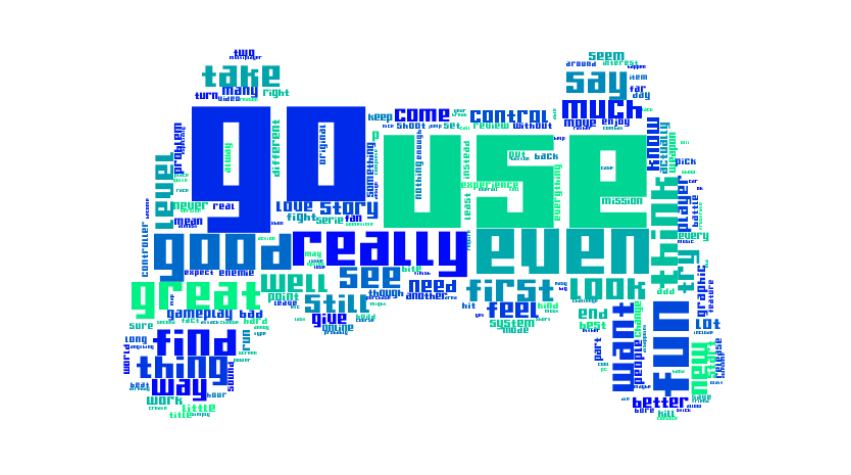

In [46]:
text = ' '.join(list(dfReview['reviewTextPreProc']))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=mask, 
                      font_path='Gamer.ttf',
                      colormap="winter",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")

In [47]:
ret, maskP = cv.threshold(cv.imread('imagens/pos.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

ret, maskN = cv.threshold(cv.imread('imagens/neg1.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

(-0.5, 899.5, 599.5, -0.5)

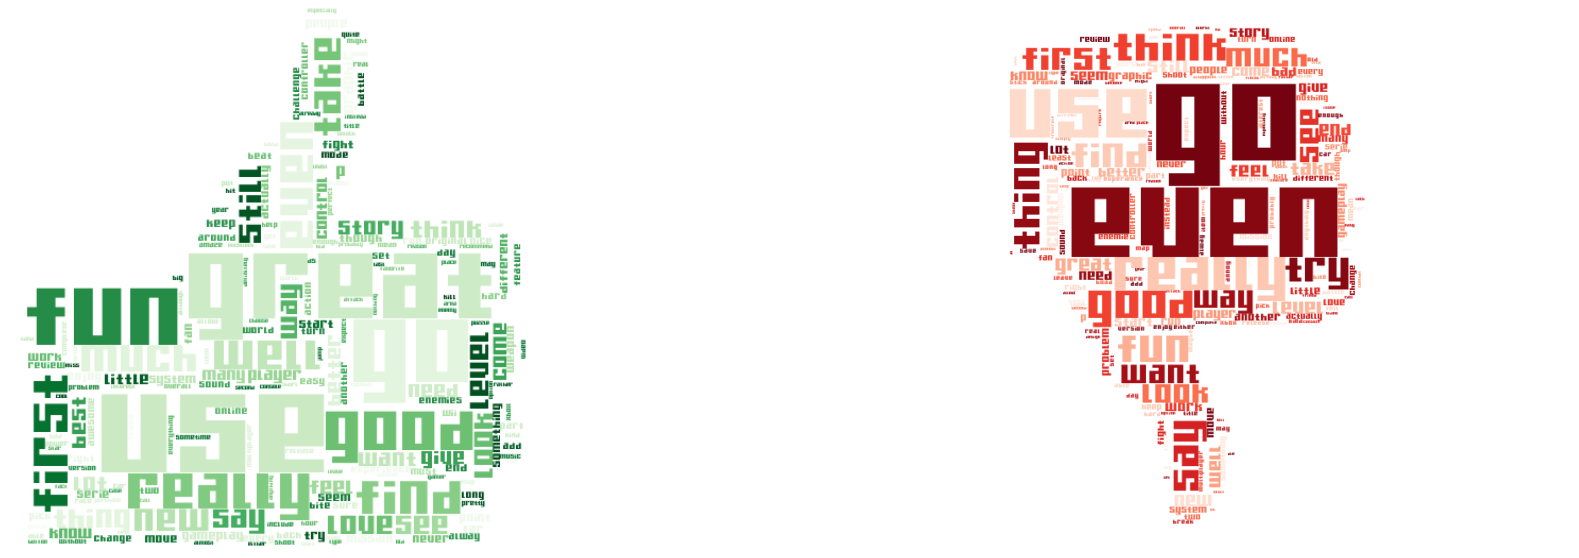

In [48]:
text = ' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc']))

wordcloudP = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskP, 
                      font_path='Gamer.ttf',
                      colormap="Greens",).generate(text)

text = ' '.join(list(dfReview[dfReview['overallBinary'] == 0]['reviewTextPreProc']))

wordcloudN = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskN, 
                      font_path='Gamer.ttf',
                      colormap="Reds",).generate(text)

fig, ax = plt.subplots(1, 2, figsize=(30,10))
ax[0].imshow(wordcloudP, interpolation='bilinear')
ax[1].imshow(wordcloudN, interpolation='bilinear')

ax[0].axis("off")
ax[1].axis("off")

#### Revendo o tamanho das reviews apos o preprocessamento

In [49]:
dfReview['lenReviewPreProc'] = dfReview['reviewTextPreProc'].apply(len)

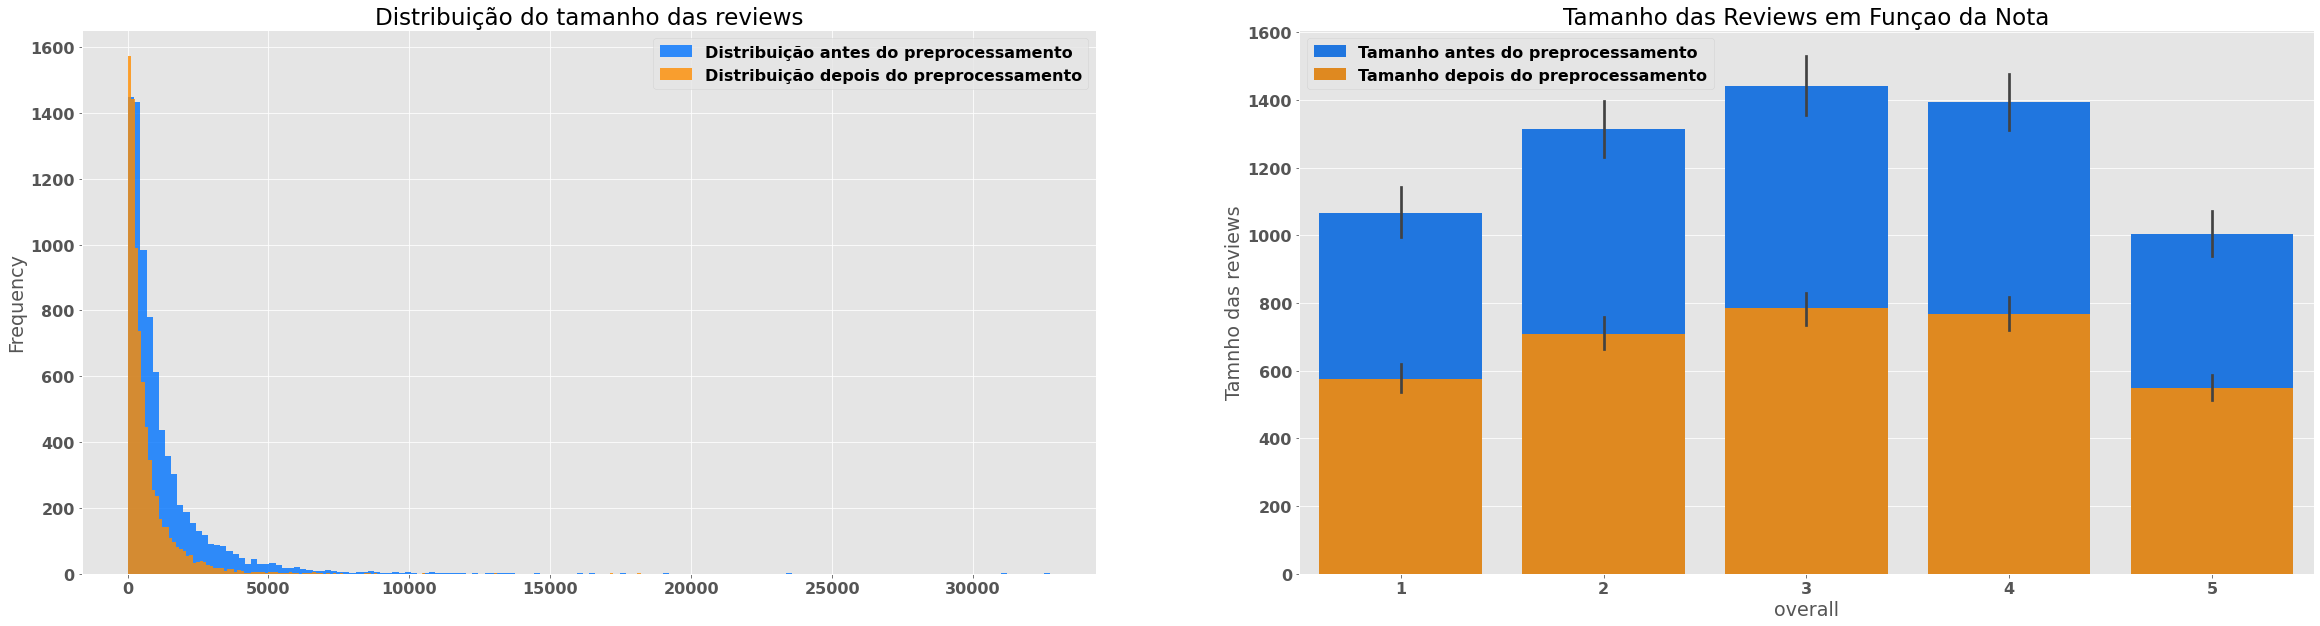

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
p = dfReview['lenReviewBruto'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='#0073ff', label='Distribuição antes do preprocessamento')
p = dfReview['lenReviewPreProc'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='#ff8c00', label='Distribuição depois do preprocessamento')
p = ax[0].legend()

p = sns.barplot(data=dfReview, x='overall', y='lenReviewBruto', color='#0073ff', label='Tamanho antes do preprocessamento', ax=ax[1])
p = sns.barplot(data=dfReview, x='overall', y='lenReviewPreProc', color='#ff8c00', ax=ax[1], label='Tamanho depois do preprocessamento')
p = ax[1].legend()
p = ax[1].set_ylabel('Tamnho das reviews')

p1 = ax[0].set_title('Distribuição do tamanho das reviews')
p1 = ax[1].set_title('Tamanho das Reviews em Funçao da Nota')

Em relacao a proporcao da distribuicao nao mudou muito, mas em valores absolutos a reviews diminuiram quase pela metade em cada nota

#### Classes gramaticais presentes

In [51]:
text = word_tokenize(' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc'])))
tags = nltk.pos_tag(text)

grammar_classes = []

for tag in tags:
    grammar_classes.append(tag[1])

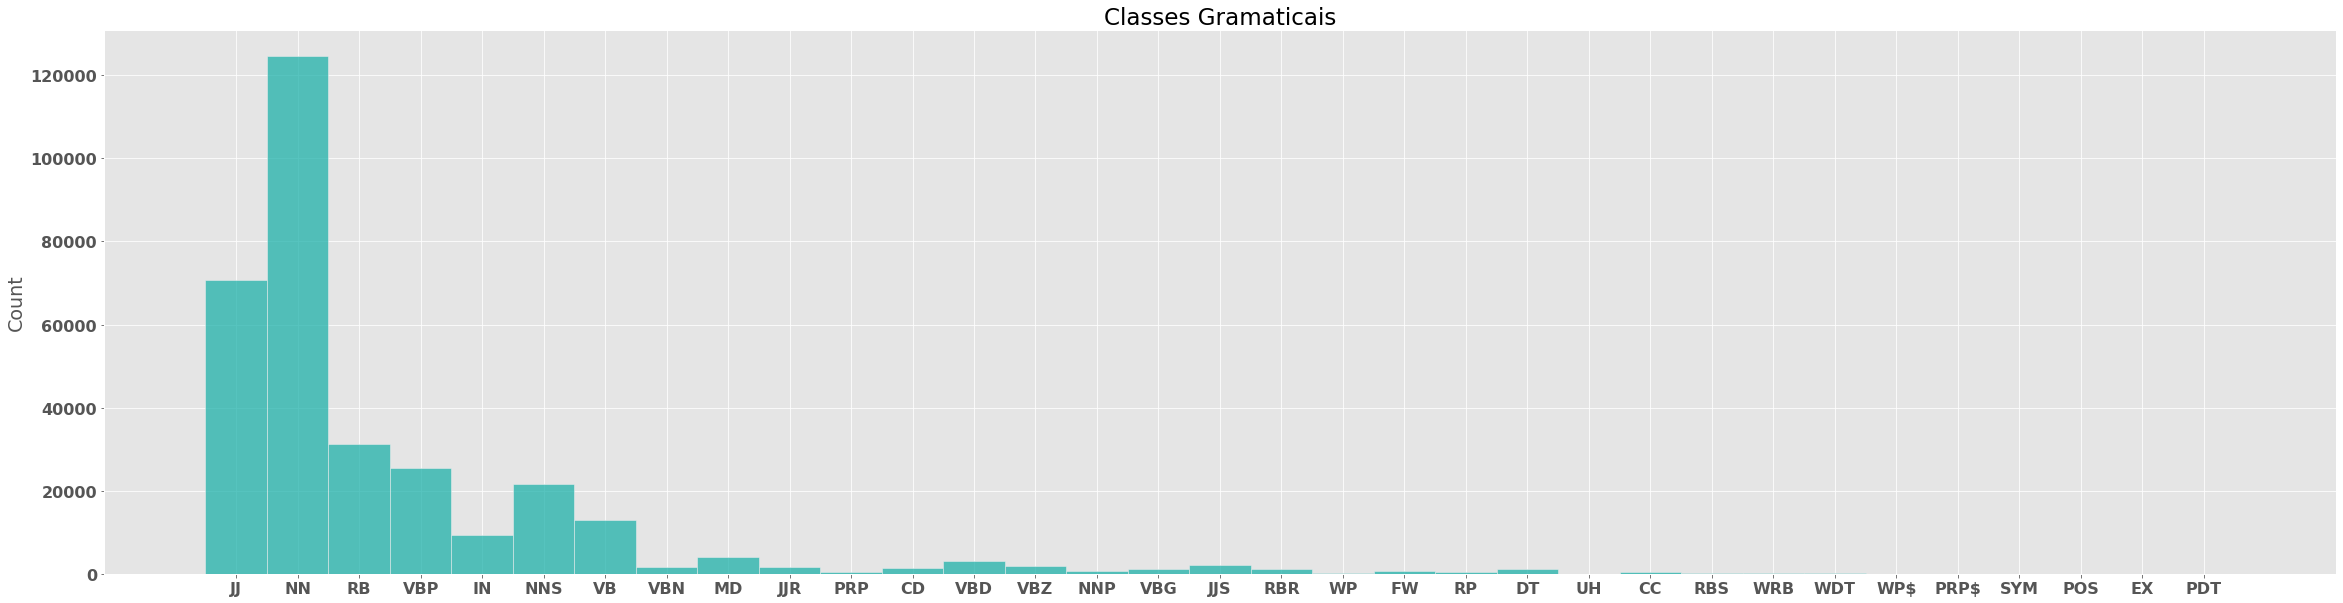

In [52]:
plt.figure(figsize=(40,10))
g = sns.histplot(grammar_classes, color='#20b2aa')
p = g.set_title('Classes Gramaticais')

A classes que mais aparecem são **substantivos (NN)**, **adjetivos (JJ)** e **advérbios (RB)** respectivamente. O dicionario completo tem [nesse link](https://sites.google.com/site/partofspeechhelp/)

#### Entidades presentes no texto

In [53]:
nlp = spacy.load("en_core_web_sm")

In [54]:
find_entities = lambda x: [str(x) for x in nlp(x).ents]

In [55]:
%%time
dfReview['entities'] = dfReview['reviewTextPreProc'].apply(lambda x:find_entities(x))

CPU times: user 2min 8s, sys: 81.4 ms, total: 2min 8s
Wall time: 2min 8s


In [364]:
ents = []
for item in list(dfReview['entities']):
    if item == []:
        pass
    else:
        ents.extend(item)

entsCount = {}
for item in list(set(ents)):
    if ents.count(item) > 3:
        entsCount[item] = ents.count(item)
    else:
        pass
    
    
ents_pos = []
for item in list(dfReview[dfReview['overallBinary'] == 1]['entities']):
    if item == []:
        pass
    else:
        ents_pos.extend(item)    

entsPosCount = {}
for item in list(set(ents_pos)):
    if ents_pos.count(item) > 3:
        entsPosCount[item] = ents_pos.count(item)
    else:
        pass
    
    
ents_neg = []
for item in list(dfReview[dfReview['overallBinary'] == 0]['entities']):
    if item == []:
        pass
    else:
        ents_neg.extend(item)
        
entsNegCount = {}
for item in list(set(ents_neg)):
    if ents_neg.count(item) > 3:
        entsNegCount[item] = ents_neg.count(item)
    else:
        pass

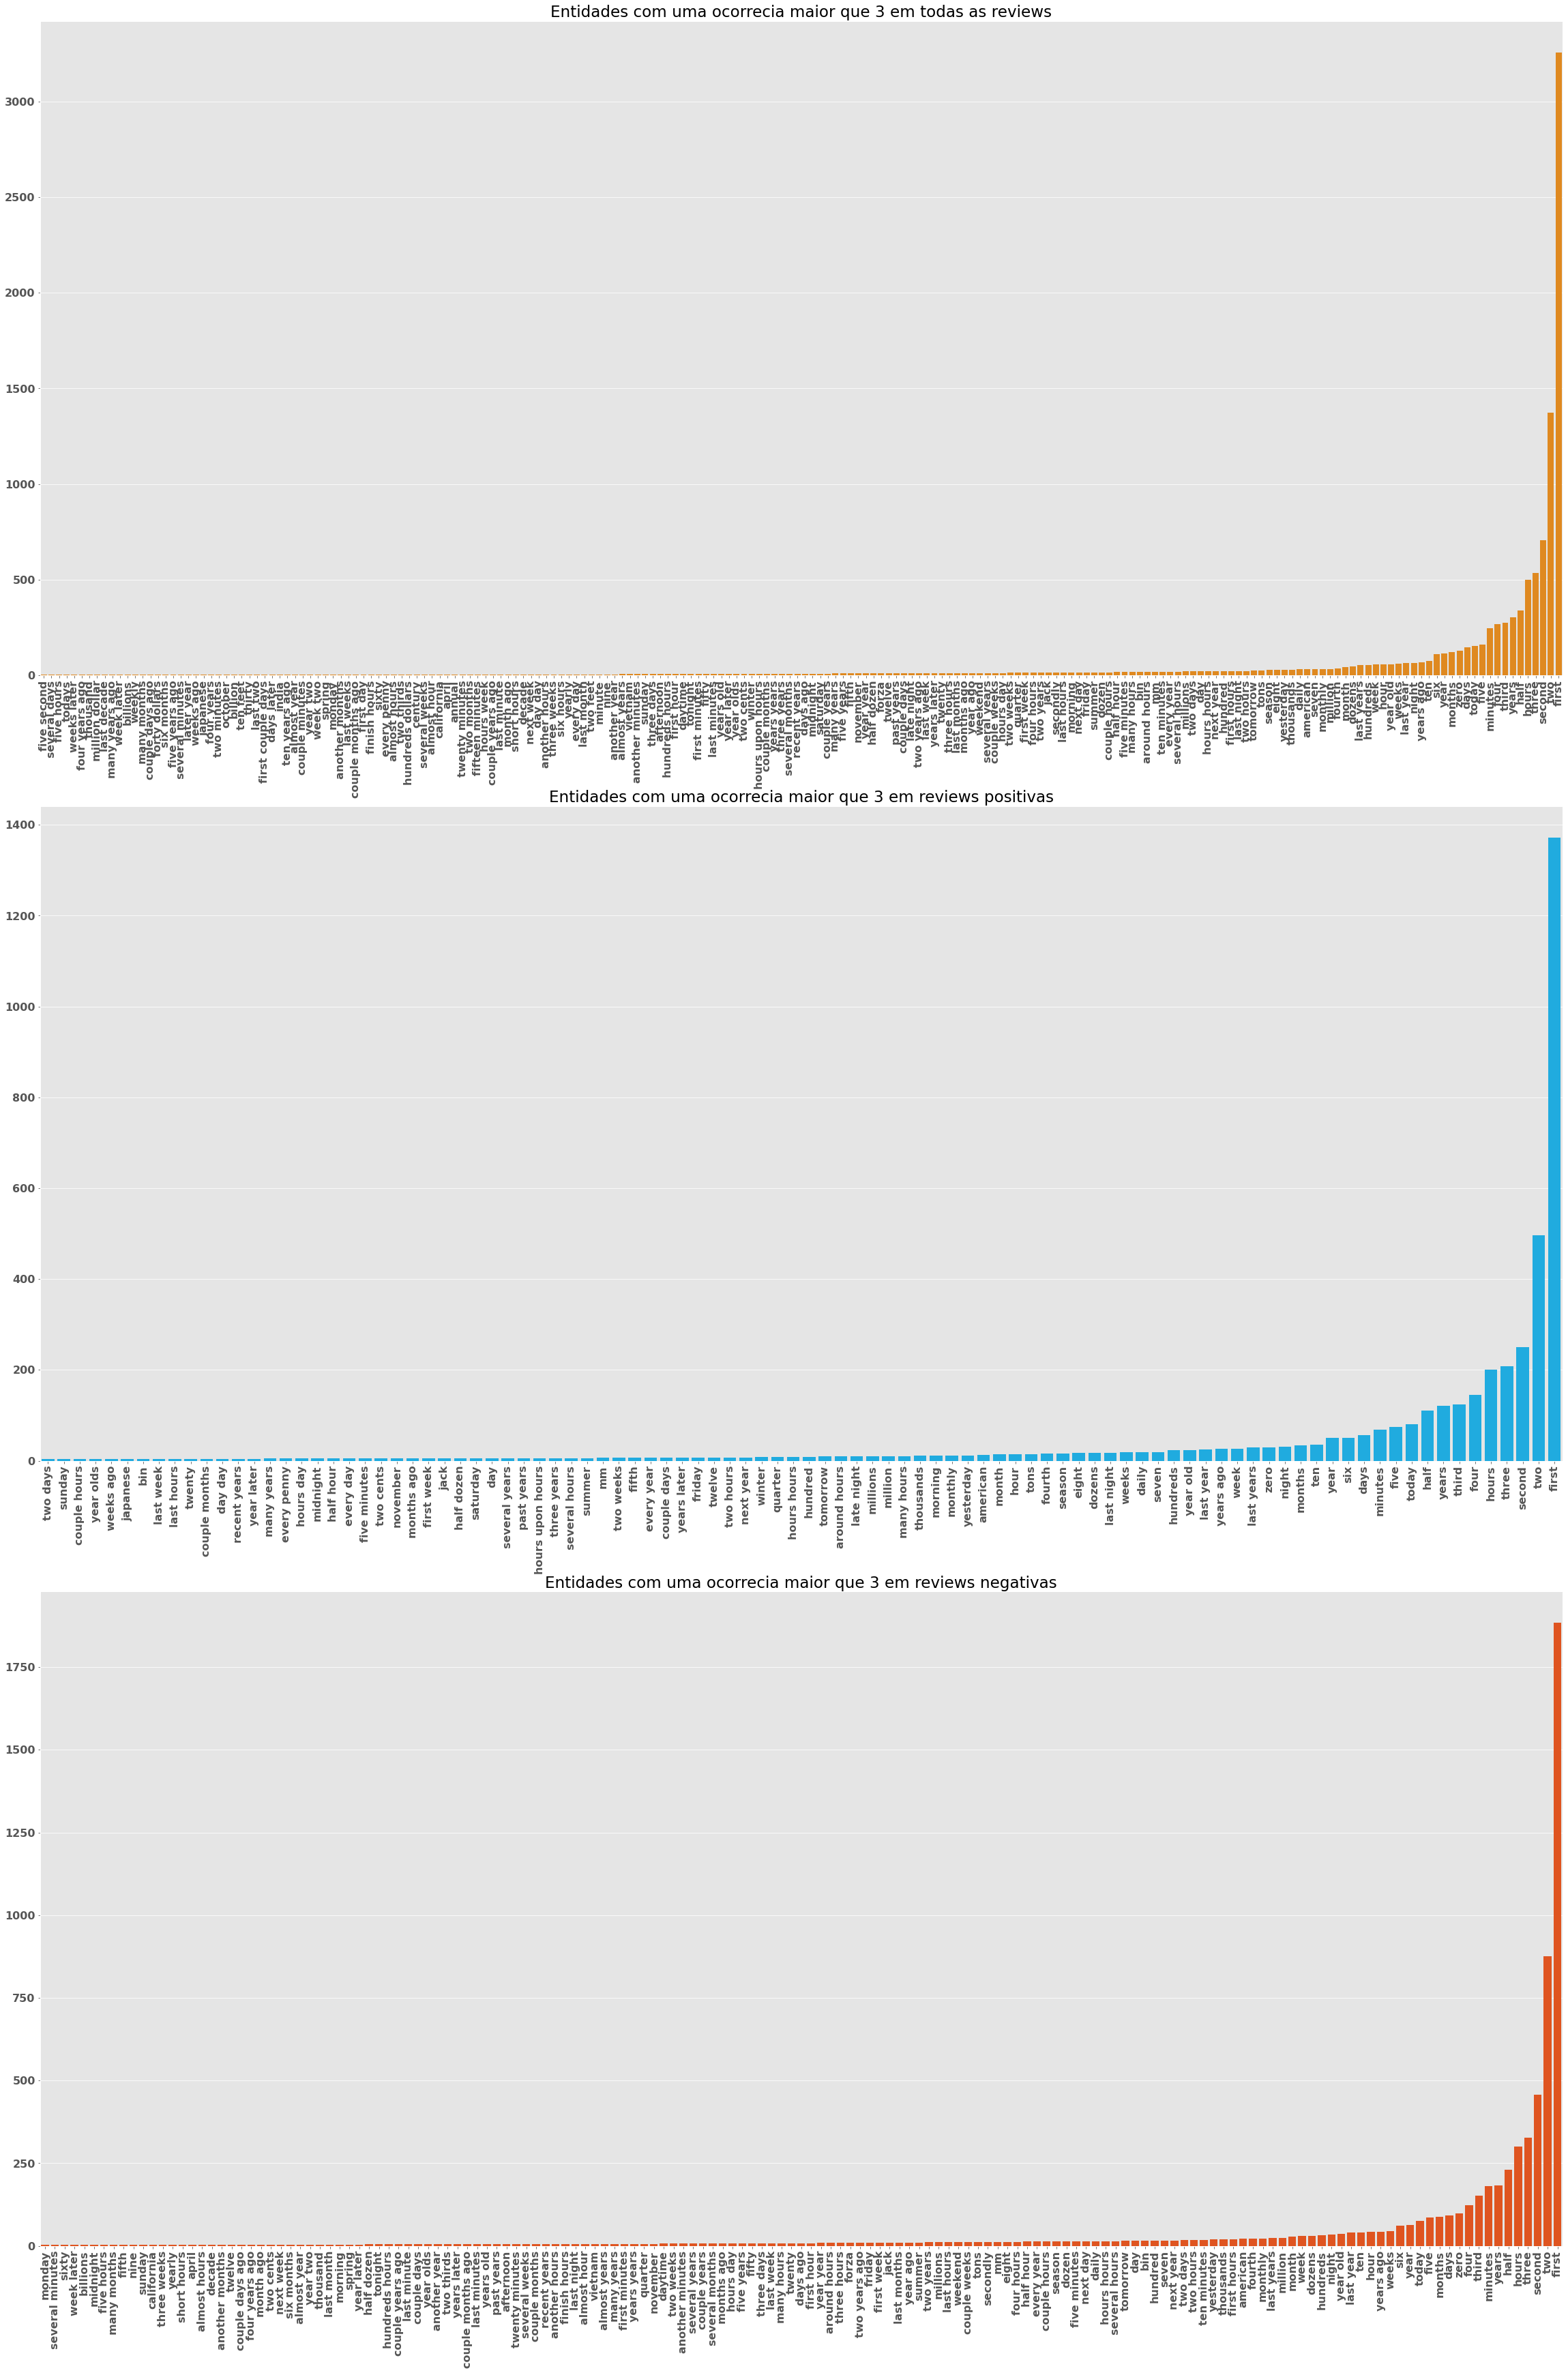

In [365]:
fig, ax = plt.subplots(3, 1, figsize=(40,60))

p = sns.barplot(x=list(entsCount.keys()), 
                y=list(entsCount.values()), 
                color='#ff8c00', ax=ax[0], 
                order=dict(sorted(entsCount.items(), key=lambda item: item[1])).keys())

p = ax[0].set_title('Entidades com uma ocorrecia maior que 3 em todas as reviews')

p = sns.barplot(x=list(entsPosCount.keys()), 
                y=list(entsPosCount.values()), 
                color='#00baff', ax=ax[1], 
                order=dict(sorted(entsPosCount.items(), key=lambda item: item[1])).keys())

p = ax[1].set_title('Entidades com uma ocorrecia maior que 3 em reviews positivas')

p = sns.barplot(x=list(entsNegCount.keys()), 
                y=list(entsNegCount.values()), 
                color='#ff4500', ax=ax[2], 
                order=dict(sorted(entsNegCount.items(), key=lambda item: item[1])).keys())

p = ax[2].set_title('Entidades com uma ocorrecia maior que 3 em reviews negativas')

p = plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=90 )
p = plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=90 )
p = plt.setp( ax[2].xaxis.get_majorticklabels(), rotation=90 )

## Modelagem

### TF-IDF

In [57]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(dfReview['reviewTextPreProc'])

In [58]:
print(X_tfidf)

(0, 24225)    0.22012037545035615
  (0, 27300)    0.3147237900766817
  (0, 26842)    0.24151448382205665
  (0, 35013)    0.4175265880699754
  (0, 4309)     0.16357987157830842
  (0, 25825)    0.15547383264208633
  (0, 38676)    0.15991101962574866
  (0, 21025)    0.30435039174936784
  (0, 8622)     0.24915149141087425
  (0, 50465)    0.46060287779364534
  (0, 12022)    0.334154527606381
  (0, 48888)    0.25459055644022527
  (1, 17023)    0.09491347892132854
  (1, 8034)     0.11336700587017066
  (1, 4879)     0.2804803936804828
  (1, 27816)    0.1708669927949179
  (1, 40416)    0.16836362802198304
  (1, 30518)    0.2654725782120725
  (1, 15815)    0.1833997672724489
  (1, 8238)     0.25725917916313307
  (1, 38954)    0.38746746097489143
  (1, 15131)    0.13302664134820755
  (1, 15745)    0.17685618504478298
  (1, 35286)    0.18463069013208291
  (1, 39491)    0.14459257509904683
  :     :
  (7999, 15803) 0.041862096707823385
  (7999, 8197)  0.06572010405321994
  (7999, 24787) 0.06791405677130855
  (7999, 49263) 0.04041964332794538
  (7999, 25918) 0.04299709003518874
  (7999, 46396) 0.0424248047234869
  (7999, 24276) 0.05657446992977641
  (7999, 18584) 0.034407834373903316
  (7999, 40040) 0.11291782258396768
  (7999, 23236) 0.27239632352642823
  (7999, 26507) 0.08889634486017908
  (7999, 12493) 0.06680226445313898
  (7999, 42252) 0.04690816175074006
  (7999, 24074) 0.050346562820652155
  (7999, 31746) 0.05775178182073119
  (7999, 19024) 0.03870205329056549
  (7999, 25574) 0.04488888075934395
  (7999, 17580) 0.04688230774768252
  (7999, 15936) 0.03883658748579461
  (7999, 11290) 0.048811757534035105
  (7999, 47702) 0.03751601199575914
  (7999, 37510) 0.049937665858169465
  (7999, 17023) 0.06977821032171488
  (7999, 15815) 0.06741564885793448
  (7999, 18458) 0.0417007246912514

In [59]:
tfidf_vocabulario = dict(zip(list(tfidf_vect.vocabulary_.values()), list(tfidf_vect.vocabulary_.keys())))

In [60]:
vocabulario_txt = []
vocabulario_values= []

for j, i in enumerate(X_tfidf.indices):
    vocabulario_txt.append(tfidf_vocabulario[i])
    vocabulario_values.append(X_tfidf.data[j])

In [61]:
vocabulario = dict(zip(vocabulario_txt, vocabulario_values))
vocabulario

{'kill': 0.03914867078246667,
 'mess': 0.05001862610788188,
 'maybe': 0.09447552701357861,
 'ps': 0.0442129906929906,
 'better': 0.03173407872932937,
 'look': 0.04941849170403782,
 'say': 0.033866798543784916,
 'honestly': 0.060776309707216154,
 'console': 0.08862377862338965,
 'xbox': 0.04091454504335061,
 'dollars': 0.1252731264446717,
 'waste': 0.09074567387242799,
 'fun': 0.06977821032171488,
 'come': 0.026524347506669765,
 'boat': 0.03907333313396481,
 'miss': 0.049922224617745,
 'simply': 0.049495370970363405,
 'occasional': 0.05823029294471724,
 'fine': 0.06741564885793448,
 'compete': 0.15661037032098915,
 'scrabble': 0.34582034139163653,
 'fan': 0.056987783241866395,
 'figure': 0.10184793819342894,
 'puzzle': 0.09176625394946501,
 'series': 0.03781663778395903,
 'give': 0.0417007246912514,
 'brain': 0.1463249712392293,
 'word': 0.05684242685085984,
 'margots': 0.4186930302037677,
 'errors': 0.14496990242894855,
 'destroy': 0.029609523221209005,
 'riddle': 0.06777445784242826,


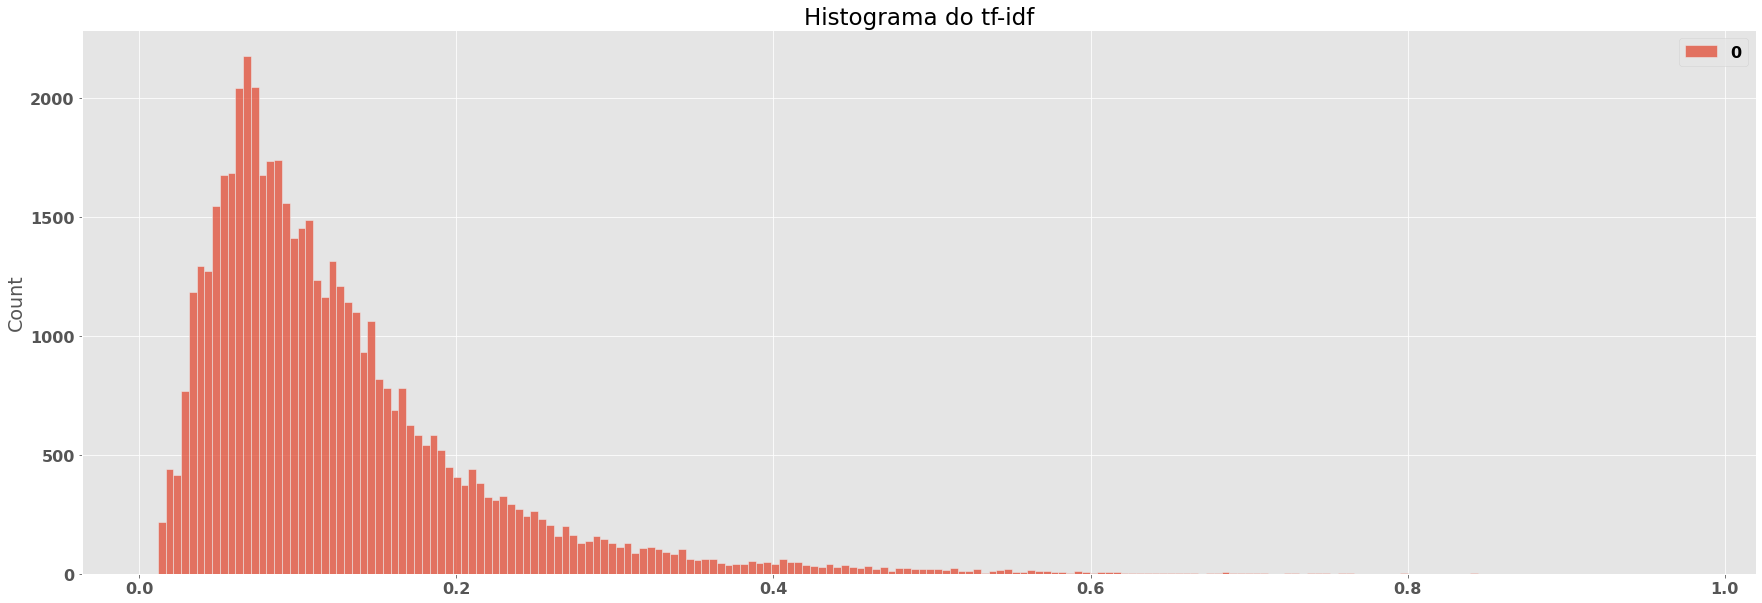

In [62]:
plt.figure(figsize=(30,10))
g = sns.histplot(vocabulario.values())
p = g.set_title('Histograma do tf-idf')

In [63]:
high_scores = dict(zip(vocabulario_values, vocabulario_txt))
high_scores_keys = list(high_scores.keys())
high_scores_keys.sort()
high_scores_keys = high_scores_keys[-100:]
high_scores = { chave: high_scores[chave] for chave in high_scores_keys }

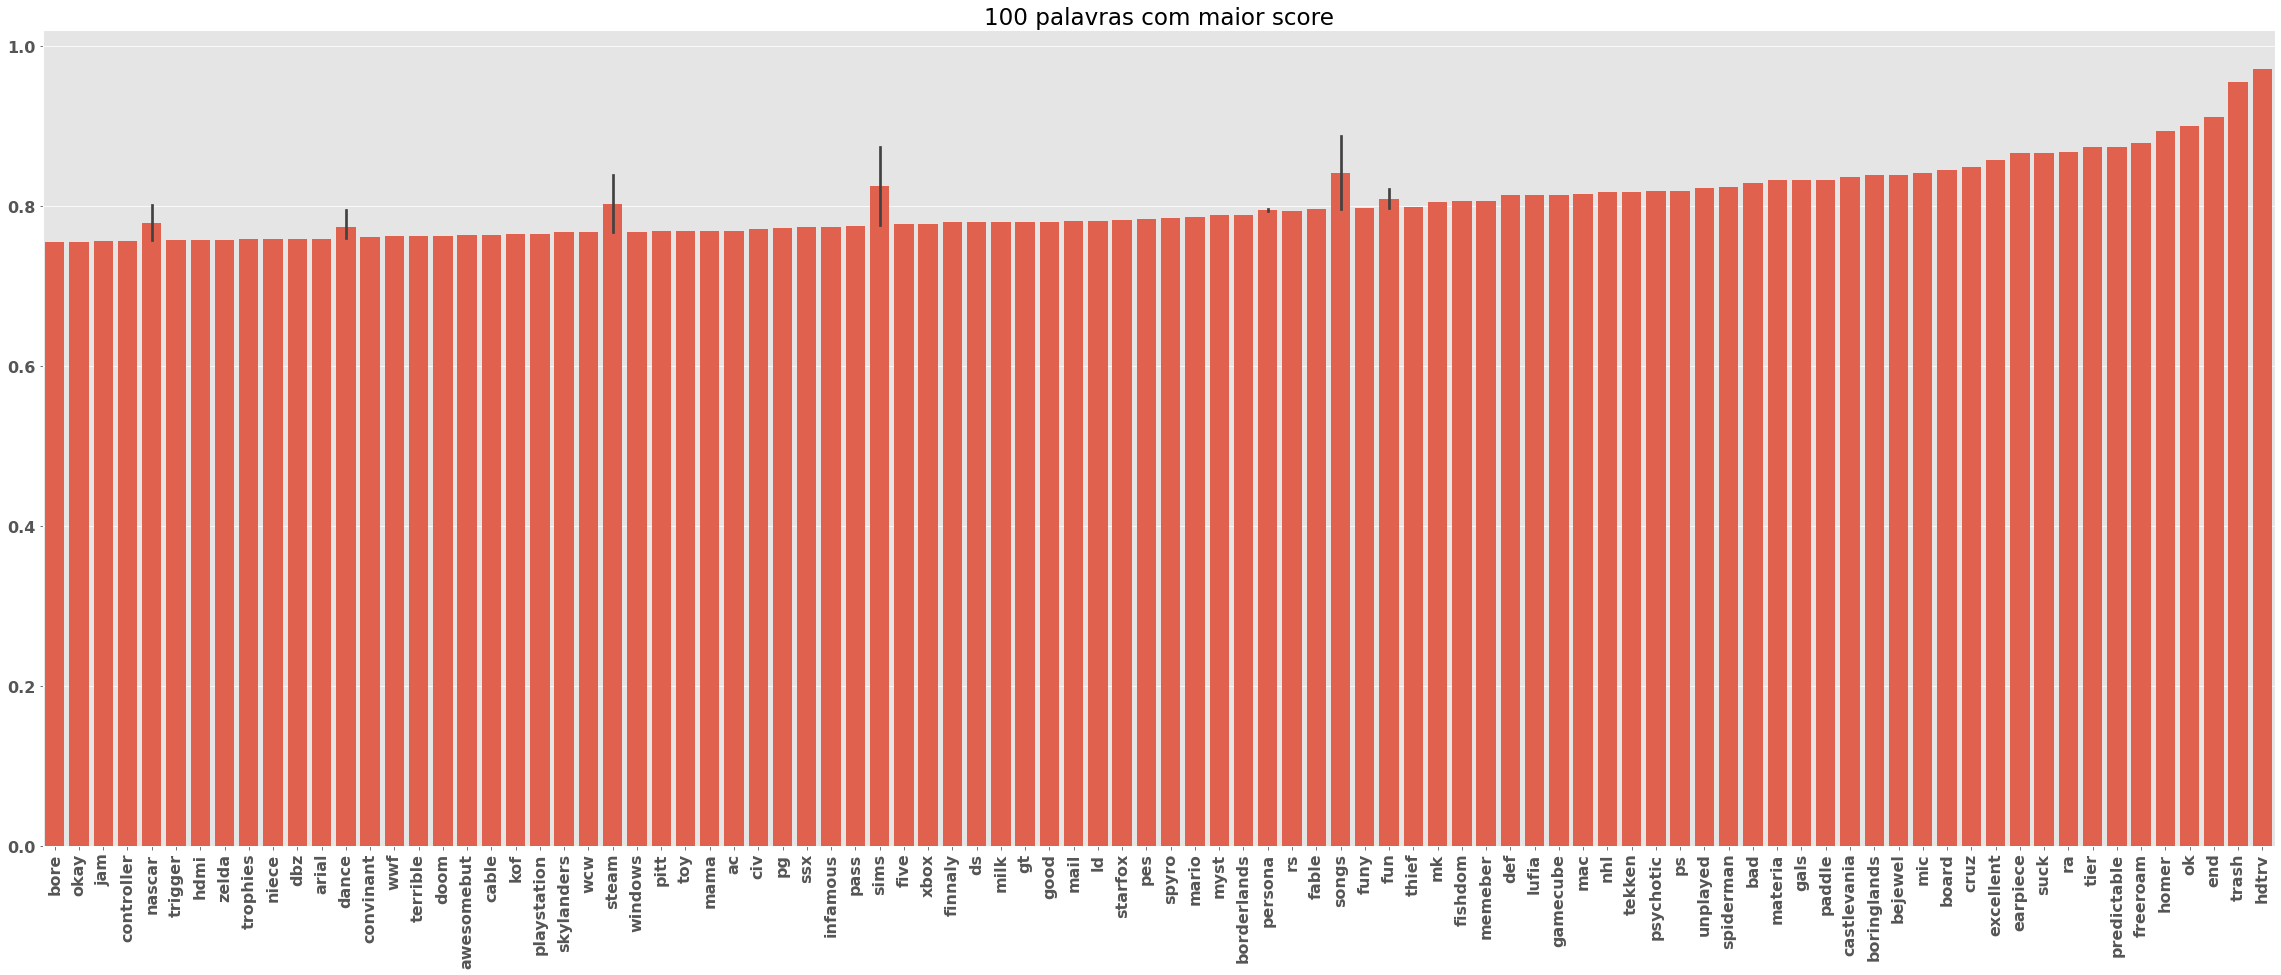

In [64]:
plt.figure(figsize=(40,15))
g = sns.barplot(x=list(high_scores.values()), y=list(high_scores.keys()), color='#f94f37')
p = plt.xticks(rotation='vertical')
p = g.set_title('100 palavras com maior score')

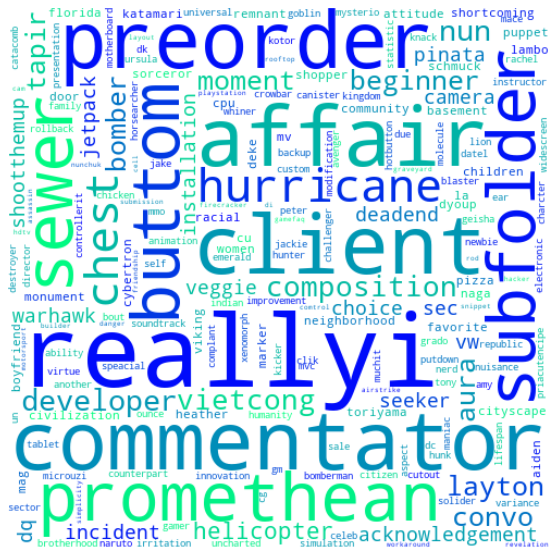

In [65]:
text = ' '.join(list(set(vocabulario_txt)))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      colormap="winter",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")

### Modelos

In [421]:
mycmap = sns.diverging_palette(220, 20, as_cmap=True)

def matriz_de_confusao(y_true, y_pred, modelo):
    plt.figure(figsize=(10,10))
    g = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap=mycmap, fmt='d')
    g.set_title('Matriz de Confusão ' + modelo)
    g.set_xticklabels(['Negativa', 'Positiva'])
    g.set_yticklabels(['Negativa', 'Positiva'])
    g.set_xlabel('Predito')
    g.set_ylabel('Real')
    
    return g

Como metricas para o modelo, decidi adotar a f-meassure pois considero ser bem adequada a situaçao ja que nao há considerar uma revew positiva com ela sendo negativa ou vce-versa acaba tendo o mesmo impacto, entao acho que media harmonica duas é suficiente. Adicionei também apenas recall para postivos e negativos pra verificar numericamente qual o desempenho os dois tipos de reviews, por exemplo: se ha uma taxa maior ou menor para cada ou se as duas distribuiçoes sao iguais.

In [448]:
def metricas(x_real, y_real):
    f1s = f1_score(x_real, y_real, average='weighted')
    p = recall_score(x_real, y_real, pos_label=1)
    n = recall_score(x_real, y_real, pos_label=0)
    
    return f1s, p, n

In [374]:
dfReviewTest = pd.read_csv('video_games_reviews_test.csv')
dfReviewDev = pd.read_csv('video_games_reviews_dev.csv')

In [375]:
# Cria os vetores de treino e teste
X_train = X_tfidf
y_train = dfReview['overallBinary']

X_test = tfidf_vect.transform(dfReviewTest['reviewText'].replace(np.nan, '').map(Preprocessamento))
y_test = dfReviewTest['overall'].apply(lambda x:1 if x > 3 else 0)

In [410]:
# Fazer o append com a acuracia dos modelos
f1_tfidf = {}
pos_tfidf = {}
neg_tfidf = {}

#### Arvores de decisao
[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [411]:
%%time
modelo_tree = DecisionTreeClassifier()
modelo_tree.fit(X_train, y_train)

CPU times: user 2.87 s, sys: 0 ns, total: 2.87 s
Wall time: 2.87 s


DecisionTreeClassifier()

In [412]:
y_pred_tree = modelo_tree.predict(X_test)

In [413]:
print(classification_report(y_test, y_pred_tree))

precision    recall  f1-score   support

           0       0.69      0.70      0.69      1512
           1       0.53      0.53      0.53       988

    accuracy                           0.63      2500
   macro avg       0.61      0.61      0.61      2500
weighted avg       0.63      0.63      0.63      2500

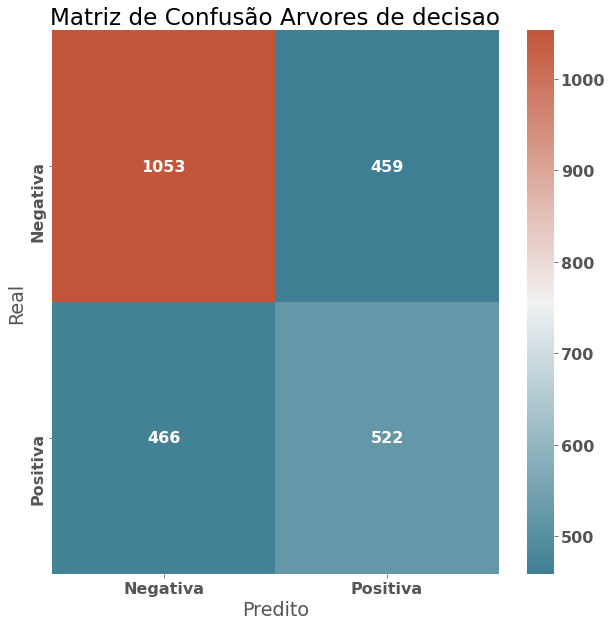

In [422]:
p = matriz_de_confusao(y_test, y_pred_tree, 'Arvores de decisao')

In [449]:
a, b, c = metricas(y_test, y_pred_tree)
m = 'Arvores de decisao'
f1_tfidf[m] = a
pos_tfidf[m] = b
neg_tfidf[m] = c

#### Random Forest
[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [416]:
%%time
modelo_rf = RandomForestClassifier(n_estimators = 200)
modelo_rf.fit(X_train, y_train)

CPU times: user 17 s, sys: 0 ns, total: 17 s
Wall time: 17 s


RandomForestClassifier(n_estimators=200)

In [417]:
y_pred_rf = modelo_rf.predict(X_test)

In [418]:
print(classification_report(y_test, y_pred_rf))

precision    recall  f1-score   support

           0       0.73      0.93      0.82      1512
           1       0.82      0.46      0.59       988

    accuracy                           0.75      2500
   macro avg       0.77      0.70      0.70      2500
weighted avg       0.76      0.75      0.73      2500

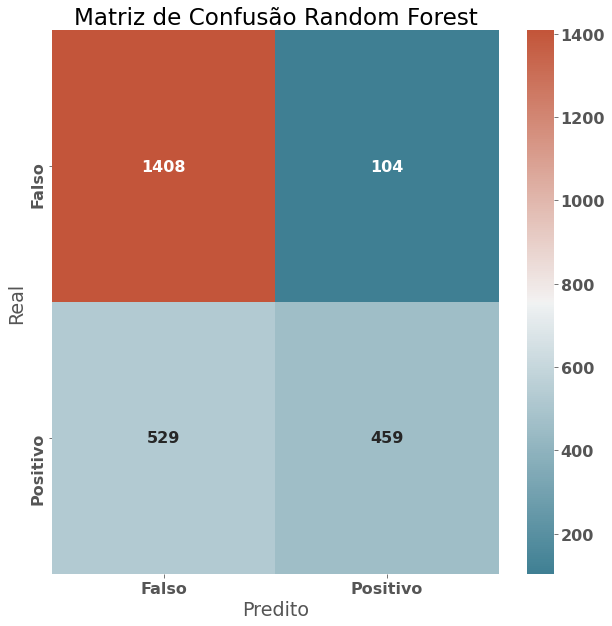

In [419]:
p = matriz_de_confusao(y_test, y_pred_rf, 'Random Forest')

In [450]:
a, b, c = metricas(y_test, y_pred_rf)
m = 'Random Forest'
f1_tfidf[m] = a
pos_tfidf[m] = b
neg_tfidf[m] = c

#### Regressao Logistica
[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [424]:
%%time
modelo_reglog = LogisticRegression()
modelo_reglog.fit(X_train, y_train)

CPU times: user 925 ms, sys: 20 ms, total: 945 ms
Wall time: 182 ms


LogisticRegression()

In [425]:
y_pred_reglog = modelo_reglog.predict(X_test)

In [426]:
print(classification_report(y_test, y_pred_reglog))

precision    recall  f1-score   support

           0       0.79      0.89      0.84      1512
           1       0.80      0.64      0.71       988

    accuracy                           0.79      2500
   macro avg       0.79      0.77      0.77      2500
weighted avg       0.79      0.79      0.79      2500

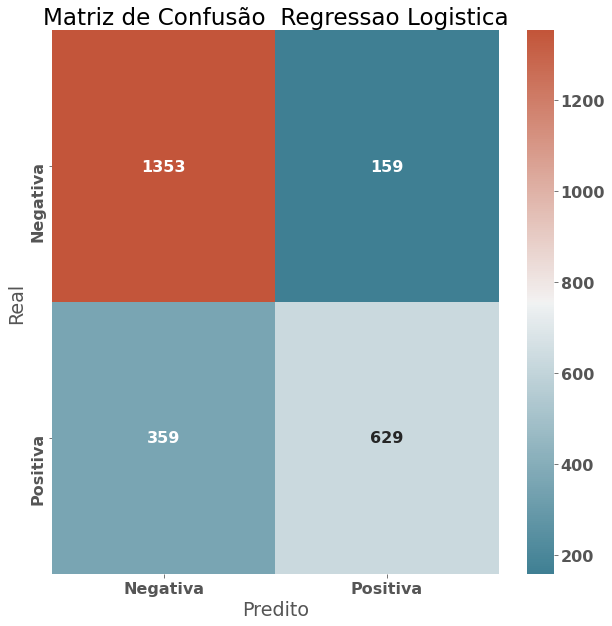

In [428]:
p = matriz_de_confusao(y_test, y_pred_reglog, ' Regressao Logistica')

In [451]:
a, b, c = metricas(y_test, y_pred_reglog)
m = 'Regressao Logistica'
f1_tfidf[m] = a
pos_tfidf[m] = b
neg_tfidf[m] = c

#### Naive Bayes
[sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [431]:
%%time
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train.toarray(), y_train)

CPU times: user 1.05 s, sys: 620 ms, total: 1.67 s
Wall time: 1.31 s


MultinomialNB()

In [432]:
y_pred_nb = modelo_nb.predict(X_test.toarray())

In [433]:
print(classification_report(y_test, y_pred_nb))

precision    recall  f1-score   support

           0       0.62      1.00      0.77      1512
           1       0.95      0.07      0.13       988

    accuracy                           0.63      2500
   macro avg       0.78      0.53      0.45      2500
weighted avg       0.75      0.63      0.52      2500

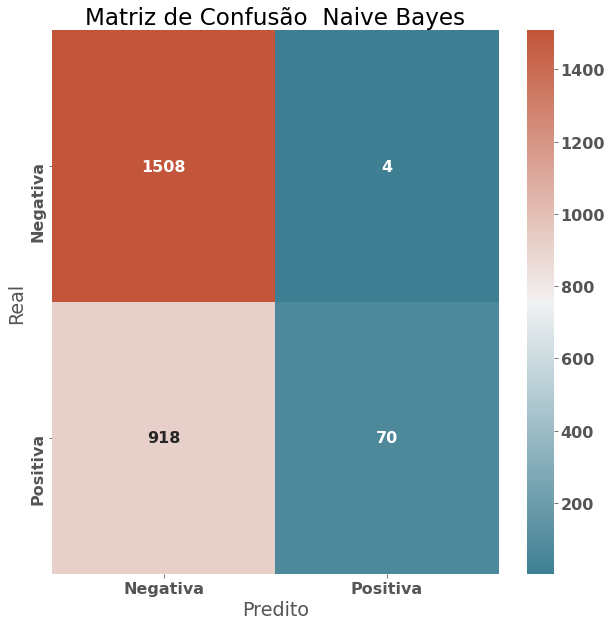

In [434]:
p = matriz_de_confusao(y_test, y_pred_nb, ' Naive Bayes')

In [452]:
a, b, c = metricas(y_test, y_pred_nb)
m = 'Naive Bayes'
f1_tfidf[m] = a
pos_tfidf[m] = b
neg_tfidf[m] = c

#### SVM 
[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [436]:
%%time
modelo_svm = SVC()
modelo_svm.fit(X_train, y_train)

CPU times: user 25.2 s, sys: 84 ms, total: 25.3 s
Wall time: 25.3 s


SVC()

In [437]:
y_pred_svm = modelo_svm.predict(X_test)

In [438]:
print(classification_report(y_test, y_pred_svm))

precision    recall  f1-score   support

           0       0.80      0.89      0.84      1512
           1       0.79      0.66      0.72       988

    accuracy                           0.80      2500
   macro avg       0.80      0.77      0.78      2500
weighted avg       0.80      0.80      0.79      2500

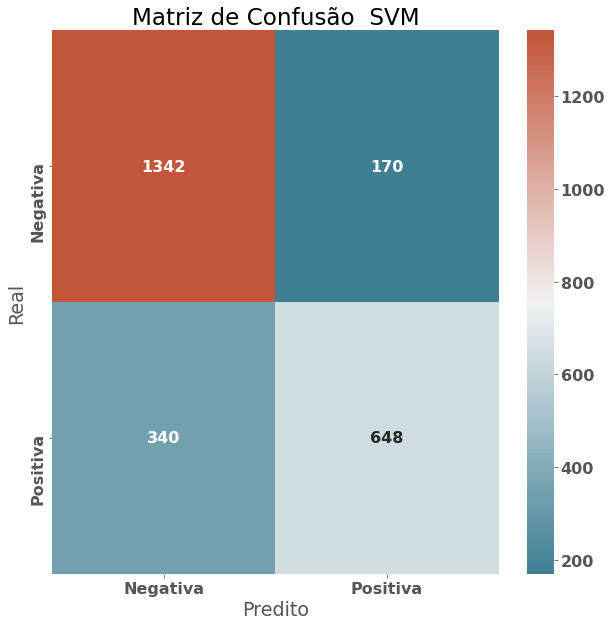

In [439]:
p = matriz_de_confusao(y_test, y_pred_svm, ' SVM')

In [453]:
a, b, c = metricas(y_test, y_pred_svm)
m = 'SVM'
f1_tfidf[m] = a
pos_tfidf[m] = b
neg_tfidf[m] = c

### Comparacao do resultado dos modelos

In [454]:
df_metricas = \
    pd.concat([pd.DataFrame(data={'modelo':f1_tfidf.keys(), 'F1-Score':f1_tfidf.values()}).set_index('modelo'),
               pd.DataFrame(data={'modelo':pos_tfidf.keys(), 'Positivas':pos_tfidf.values()}).set_index('modelo'),
               pd.DataFrame(data={'modelo':neg_tfidf.keys(), 'Negativas':neg_tfidf.values()}).set_index('modelo')],
             axis=1, join='inner')

df_metricas

,F1-Score,Positivas,Negativas
modelo,,,
Arvores de decisao,0.629770,0.528340,0.696429
Random Forest,0.727710,0.464575,0.931217
Regressao Logistica,0.787560,0.636640,0.894841
Naive Bayes,0.515297,0.070850,0.997354
SVM,0.791828,0.655870,0.887566


In [455]:
df_metricas.describe()

,F1-Score,Positivas,Negativas
count,5.000000,5.000000,5.000000
mean,0.690433,0.471255,0.881481
std,0.117746,0.237204,0.112205
min,0.515297,0.070850,0.696429
25%,0.629770,0.464575,0.887566
50%,0.727710,0.528340,0.894841
75%,0.787560,0.636640,0.931217
max,0.791828,0.655870,0.997354


In [456]:
df_metricas.reset_index()

,modelo,F1-Score,Positivas,Negativas
0,Arvores de decisao,0.629770,0.528340,0.696429
1,Random Forest,0.727710,0.464575,0.931217
2,Regressao Logistica,0.787560,0.636640,0.894841
3,Naive Bayes,0.515297,0.070850,0.997354
4,SVM,0.791828,0.655870,0.887566


Text(0.5, 1.0, 'Desempenho dos modelos')

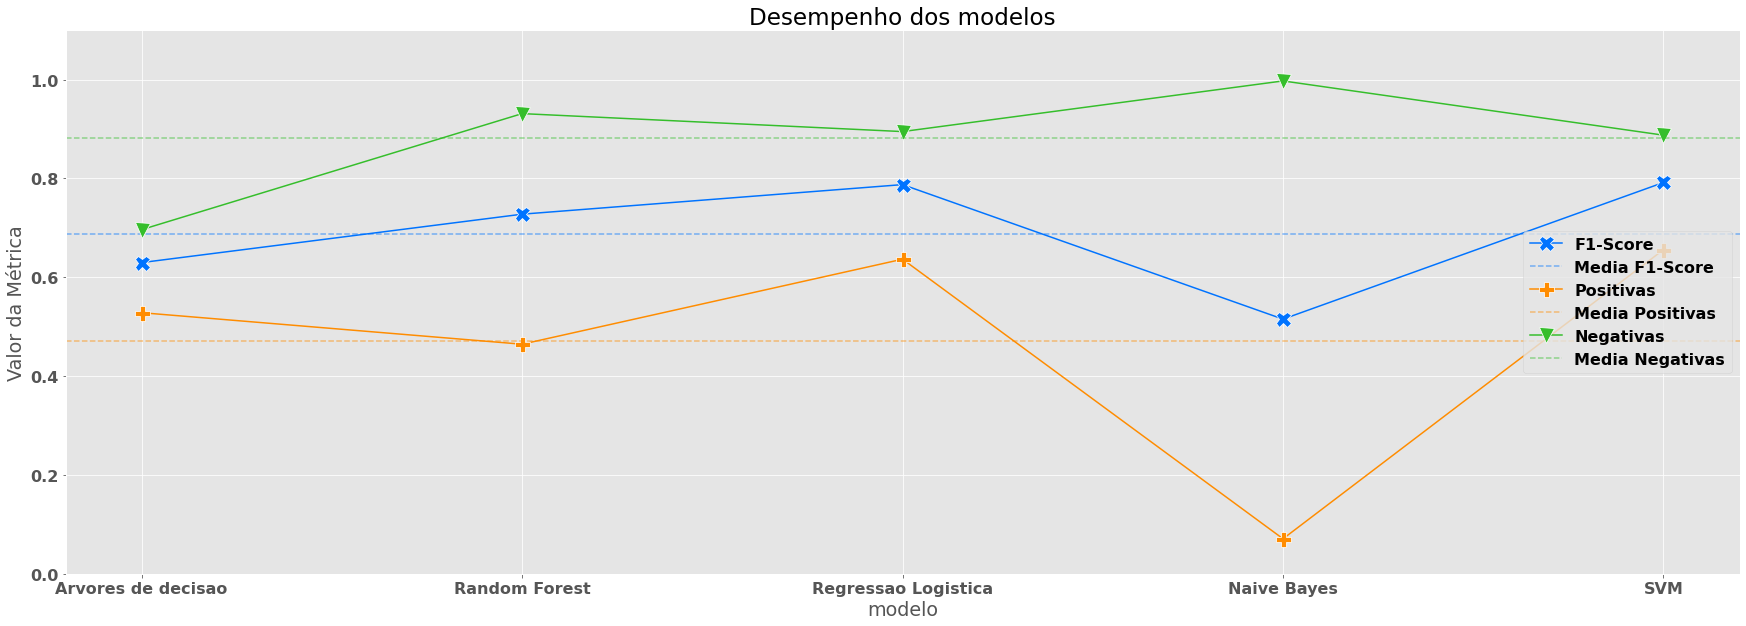

In [458]:
fig, ax = plt.subplots(figsize=(30, 10))

sns.lineplot(data=df_metricas.reset_index(), x='modelo', y='F1-Score', ax=ax, marker='X', markersize=15, label='F1-Score', color='#0073ff')
p = ax.axhline(np.mean(list(acc_tfidf.values())), color='#0073ff', label='Media F1-Score', linestyle='--', alpha=.5)

sns.lineplot(data=df_metricas.reset_index(), x='modelo', y='Positivas', ax=ax, marker='P', markersize=15, label='Positivas', color='#ff8c00')
p = ax.axhline(np.mean(list(pos_tfidf.values())), color='#ff8c00', label='Media Positivas', linestyle='--', alpha=.5)

sns.lineplot(data=df_metricas.reset_index(), x='modelo', y='Negativas', ax=ax, marker='v', markersize=15, label='Negativas', color='#35BE2B')
p = ax.axhline(np.mean(list(neg_tfidf.values())), color='#35BE2B', label='Media Negativas', linestyle='--', alpha=.5)

ax.legend(loc=7)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Valor da Métrica')
ax.set_title('Desempenho dos modelos')

Avaliando o desempenho dos modelos como um todo, SVM e regressão logistica são os que tem as melhores metricas! E Naive Bayes tem a pior, cheguei a fazer algumas modificaçoes no pre-processamento como nao remover mais as palavras (game, play, ...) pois poderiam ter alguma relevancia, mas nao alterou muito o resultado, entao voltei as coisas como estavam, não consegui enterder muito bem o mal desempenho do modelo ja que em alguns notebooks que encontrei de analise de sentimento como [esse](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos) o naive bayes apresentou bons resultados. 
Mas achei interessante observar o desempenho dos modelos frente as duas classificaçoes (positivas e negativas) e a taxa de acerto em reviews negativas é sempre maior que em negativas, não sei se por ter uma amostra de negativas superior no contunto de teste como visto anteriormente ou por possuirem palavras, a meu ver, mais significativas e por isso uma maior adptcao do modelo as essas reviews. E isso vemos ate no Naive Bayes que teve uma taxa de acertos em reviews negativas  acima da media dos demais modelos!!! Ou seja a o mal desempenho Naive vai pra baixo só pelas reviews positivas, ja que taxa de acertos em negativas é otimo!!! 
Abaixo vou testar algumas reviews que eu peguei no site da amazon e ver como ficam com coisas que estao fora do conjunto.
Mas levando em conta SVM e regressão logistica as taxas de acerto sao bem parecidas em casos positivos e negativos, entao vou tentar dar uma melhorada neles!

#### Analise de reviews aleatorias

Escolhi na amazon algumas reviews positivas e negativas de jogos lançados a aprtir de 2015 e vou passar elas pelos modelos pra ver o desempenho

In [295]:
reviwes_positivas = [
    'This product is CLEARLY the new God of War 2018, if you know anything about the series you can tell by just the cover not to mention Amazon provides a proper description on the page. Disregard that 1 star review this is a 10/10 beautiful game worth full price.',
    '''I have to admit that I wasn't sold on this version of Kratos and his ongoing story as it just felt so different compared to the other 3 games. Once I bought and played it... I honestly understand why it got Game Of The Year because it is such an emotional yet wonderful experience. I found myself going back into the world even after completing everything because I love the detail and graphics that instantly transported me into Kratos' world. Another point that I want to make is that it was pretty hard for me to get into it because the dynamic between Kratos and Atreus felt harsh and empty, I felt no connection to the characters nor did I feel like rooting for them. I'm glad that I pushed on because it opens up much more that makes me see it differently and appreciate the dynamic even more by the end. If you decide to play it and feel like I did, for sure you should play till the end as it gets so much better.''',
    "it's been over a month since i bought this game and i'm really enjoying it but the call of duty campaign is blocked, could someone help me? thanks.",
    "This game is really good and I think u should buy it if you’re a real gamer. At first when I started playing it I think it was bad and boring but then I continue playing it and I saw there’s so much to do and it is getting addicting for me. There’s another mission/challenge to do after u complete one so you won’t be bored unless u get tired. I can’t explain everything but get the game and u will definitely enjoy it. It’s worth the price, thank me later.",
    "Ordered yesterday. Got $10 discount plus gift card from Amazon. Arrived today. Great game! What more could you ask for?",
    """Watch Dogs Legion is a very good game. It certainly lives up to what we've expected it to be. The change of location takes some getting use to as you'll be driving on the opposite side of the road but all in all it's still fun. The use of non lethal weapons might get tiresome on missions but you'll have a good time taking down enemies with cyber tactics. If you're a gamer like me you can appreciate the graphics, especially in the Playstation Pro, and thanks to Sony you can enjoy a free upgrade to the PS5 version when played on the Playstion 5. All in all I give Watch Dogs Legion a solid 9 out of 10.""",
    "The game is amazing and I like how they made the game base in London and famous monuments. The game was easy but I loved going out and getting everything you could to beat the game! Way better than the first one.",
    "I actually bought this for my brother for Christmas because he really wants and I’m very familiar with the watchdogs game series I’ve played them all and they are awesome games!",
    "this is the cheapest ive found for this game which made me a little skeptical at 1st but it came the next day and my gf loves it and hasnt stopped playin it since christmas lol",
    
]

In [296]:
reviwes_negativas = [
    '''There wasn't any description about the item and I was hoping it was actually the FIRST GOW re-released on the PS4 but it's not. This is just a "playstation hits" version of the latest God of War game.

Having the name "God of War Hits" is NOT ACCURATE and needs to be changed to "Playstation Hits, God of War".''',
    '''Buyer beware nowhere on the selling information dose it say downloadable version only , I thought that I was getting the full gaming disc version and the send me a cut out of another game pkg with a code on it , did not want to download to the console and this is just a total misrepresentation of the product they are selling , so if you don’t mind buying something like this and take a chance that the code doesn’t work go right ahead and buy it !''',
    'The case was shattered',
    'There is no reason to drop $60 on this dumpster fire. Just go to YouTube and skip all the BS.',
    'Horrible story. Studies can’t get away with such horrible writing and pay off the critics to get people to buy into their product',
    '''The story is terribly written, there is no payoff to gamers that enjoyed the first game. They focus on the new characters while taking a dump on the characters we fell in love with (Joel / Ellie). If you loved the first game, and you appreciated the bonds between the two main characters, you'll feel betrayed by Naughty Dog on this one.''',
    "This is the most BORING Assasinss Creed I 've ever played!! Literally is 99% Himalaya climbing. Super boring!",
    "Ps4 can't play through because of a bug. First hour of game play can't progress story because the cut scene won't load.",
    "I love the game so far, even after I literally only did two quests. There’s a hand breaking bug that makes “A seer’s solace” unplayable. So I would recommend not buying the game until it’s fixed:) Thanks Ubisoft"
]

In [297]:
def predicao(texto):
    texto_vetorizado = tfidf_vect.transform([texto])
    
    predicoes = []
    
    predicoes.append(modelo_tree.predict(texto_vetorizado)) 
    predicoes.append(modelo_rf.predict(texto_vetorizado)) 
    predicoes.append(modelo_nb.predict(texto_vetorizado)) 
    predicoes.append(modelo_svm.predict(texto_vetorizado)) 
    predicoes.append(modelo_reglog.predict(texto_vetorizado)) 
    
    predicoes = ['negativa' if i == 0 else 'positiva' for i in predicoes]
    
    return predicoes

In [298]:
idx = ['Arvore de Decisao', 
       'Florestas aleatorias', 
       'Naive Bayes', 
       'SVM', 
       'Regressao Logistica']

In [299]:
pos_predict = np.array(list(map(predicao, reviwes_positivas)))
neg_predict = list(map(predicao, reviwes_negativas))

In [300]:
acertos = 0
modelDict = {}
for i, modelo in enumerate(idx):
    modelDict[modelo] = []
    for r in range(len(reviwes_positivas)):
        if pos_predict[r, i] == 'positiva': acertos += 1 
    modelDict[modelo].append(acertos)
    acertos = 0

In [301]:
acertos = 0
for i, modelo in enumerate(idx):
    for r in range(len(reviwes_negativas)):
        if pos_predict[r, i] == 'negativa': acertos += 1 
    modelDict[modelo].append(acertos)
    acertos = 0

In [302]:
dfPred = pd.DataFrame(data=modelDict, index=['positiva', 'negativa'])

In [303]:
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

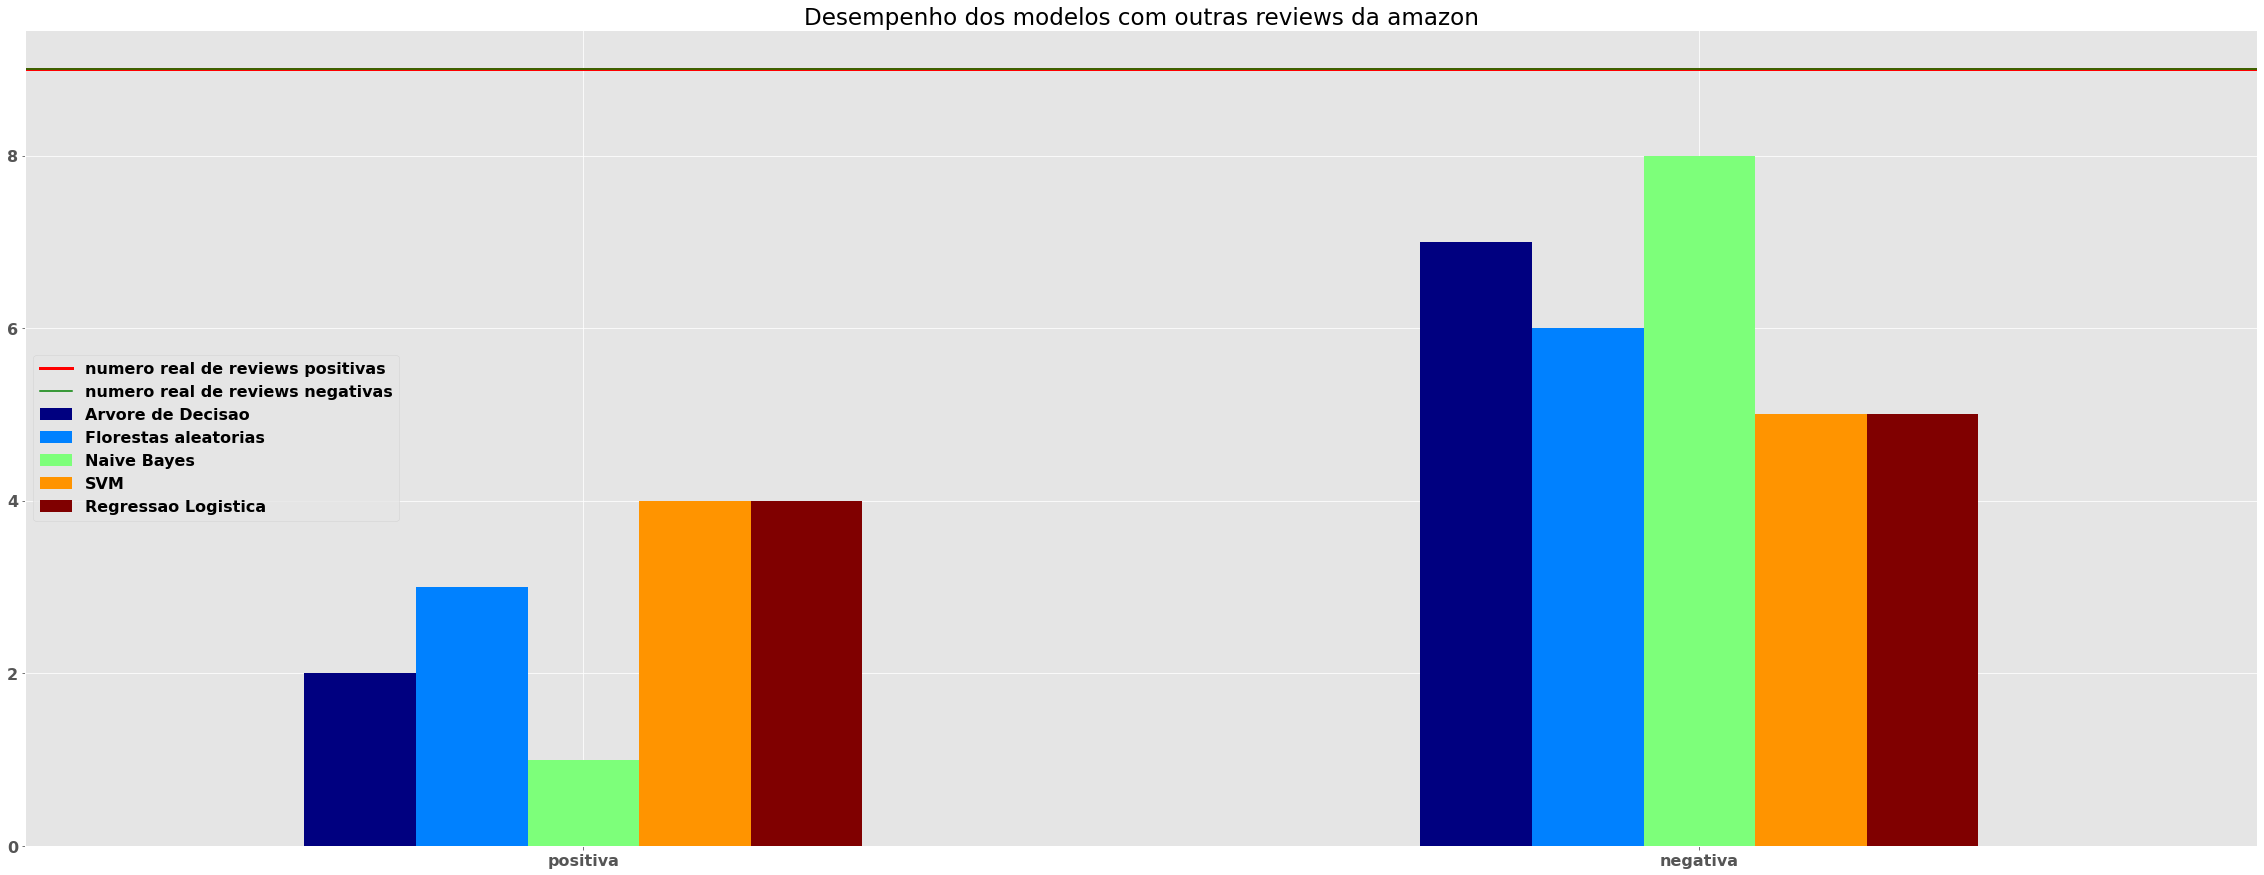

In [304]:
g = dfPred.plot(kind='bar', figsize=(40, 15), cmap='jet')
p = g.axhline(len(pos_predict), label='numero real de reviews positivas', color='red', linewidth=3)
p = g.axhline(len(neg_predict), label='numero real de reviews negativas', color='green')
p = g.legend(loc=0)
p = g.set_title('Desempenho dos modelos com outras reviews da amazon')
p = plt.xticks(rotation='horizontal')

Meu Deus! O Naive é muito bom em detectar reviews negativas mas nao funciona com positivas!!! E Arvores de decisao fica um pouco parecido, uma proporcao menor, mas ainda sim bem discrepante, e eu nao entendi o pq

![stress](https://media3.giphy.com/media/Ofo2Z3DnjvAHa4WJOf/200w.webp?cid=ecf05e47643z8jzu5atn8uqfy8njk9qyqlwngnbxdy09lqu3&rid=200w.webp&ct=g)


Mas ok, vida que segue, considerando um desempenho geral vou tentar dar uma otimizada no SVM e RegLog que tem bons desempenhos 

![no stress](https://media0.giphy.com/media/H3M83lTt5nDcS5YgSY/200w.webp?cid=ecf05e47yzr1qz3eisde6b22phx8iyb800igpgl19sawv5qg&rid=200w.webp&ct=g)

### Otimização de hiperparametros do SVM e Regressao Logistica

In [306]:
dfReviewValid = pd.read_csv('video_games_reviews_dev.csv')

Minha ideia é juntar o conjunto de validaçao junto com de treino (ambos pré processados) pra ter um conjunto maior ... eu não sei se é assim que se faz '-' Mas vi alguns videos e artigos sobre o dev set ai entendi que era assim

![](https://media2.giphy.com/media/1d7F9xyq6j7C1ojbC5/200.webp?cid=ecf05e47k0xw75qwuo4us7ynla7e687cd8pjk4w6nnr2u47r&rid=200.webp&ct=g)

In [322]:
texto_dev = list(dfReviewDev['reviewText'].replace(np.nan, '').map(Preprocessamento))
texto = list(dfReview['reviewTextPreProc'])
texto.extend(texto_dev)

In [332]:
label_dev = list(dfReviewDev['overall'].apply(lambda x:1 if x > 3 else 0))
label = list(dfReview['overallBinary'])
label.extend(label_dev)

In [333]:
len(texto), len(label)

(10000, 10000)

In [334]:
X_devTrain = tfidf_vect.transform(texto)
y_devTrain = label

#### SVM

[Hipeparametros SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [356]:
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

In [360]:
%%time
grid = GridSearchCV(SVC(),
                    param_grid,
                    refit=True,
                    verbose=2,
                    scoring='accuracy')

grid.fit(X_devTrain, y_devTrain)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  29.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  28.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  28.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  28.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  30.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  39.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  38.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  37.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 147.1min finished


CPU times: user 2h 29min 32s, sys: 483 ms, total: 2h 29min 33s
Wall time: 2h 29min 34s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [363]:
print('Melhor kernel: {}'.format(grid.best_params_['kernel']))
print('Melhor valor para gamma: {}'.format(grid.best_params_['gamma']))
print('Melhor valor para C: {}'.format(grid.best_params_['C']))
print('PMaior acuracia obtida: {}'.format(round(grid.best_score_,3)))
print('Melhor estimador: {}'.format(grid.best_estimator_))

Melhor kernel: rbf

Melhor valor para gamma: 1

Melhor valor para C: 10

PMaior acuracia obtida: 0.809

Melhor estimador: SVC(C=10, gamma=1)

2h 29min 32s e um ganho de ~0.009 do modelo sem otimizaçao


![](https://media3.giphy.com/media/L95W4wv8nnb9K/200w.webp?cid=ecf05e47d3ukqtt1ydl4ipj0rdbb24emhn5znjtcn4flznty&rid=200w.webp&ct=g)


Mas foi com outra parametrizaçao, diferente da default que eu havia usado

In [367]:
svm_opt = SVC(C=10, gamma=1)
svm_opt.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [368]:
y_pred_svm_opt = svm_opt.predict(X_test)

In [369]:
print(classification_report(y_test, y_pred_svm_opt))

precision    recall  f1-score   support

           0       0.81      0.86      0.83      1512
           1       0.77      0.68      0.72       988

    accuracy                           0.79      2500
   macro avg       0.79      0.77      0.78      2500
weighted avg       0.79      0.79      0.79      2500

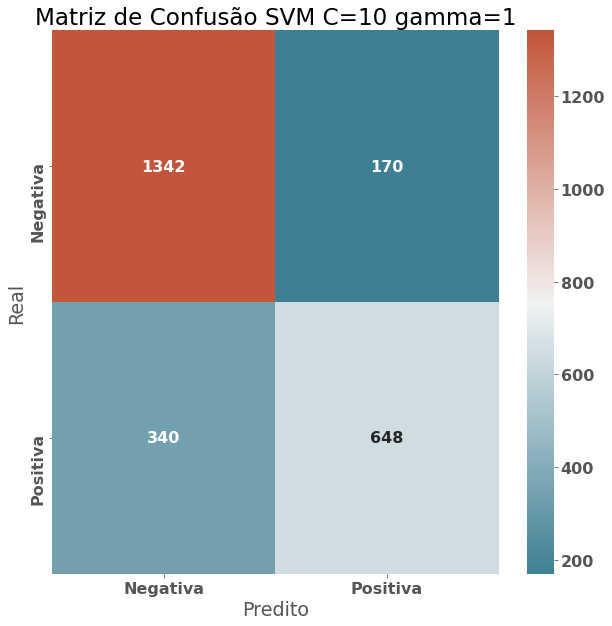

In [464]:
p = matriz_de_confusao(y_test, y_pred_svm, 'SVM C=10 gamma=1')

#### RegLog
[Hiperparametros RegLog](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [461]:
%%time
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

clf = GridSearchCV(LogisticRegression(), 
                   param_grid, 
                   scoring='accuracy',
                   refit=True,
                   verbose=2)

clf.fit(X_devTrain, y_devTrain)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.1s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................... C=0.001, total=   0.4s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.1s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .

/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................................ C=100, total=   1.1s
[CV] C=100 ...........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................................ C=100, total=   0.6s
[CV] C=100 ...........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................................ C=100, total=   0.6s
[CV] C=100 ...........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................................ C=100, total=   0.6s
[CV] C=100 ...........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................................ C=100, total=   0.7s
[CV] C=1000 ..........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ........................................... C=1000, total=   0.7s
[CV] C=1000 ..........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ........................................... C=1000, total=   0.7s
[CV] C=1000 ..........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ........................................... C=1000, total=   0.7s
[CV] C=1000 ..........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ........................................... C=1000, total=   1.0s
[CV] C=1000 ..........................................................


/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   12.9s finished


[CV] ........................................... C=1000, total=   0.7s
CPU times: user 1min 6s, sys: 1.1 s, total: 1min 7s
Wall time: 13.4 s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy', verbose=2)

In [463]:
print('Melhor valor para C: {}'.format(clf.best_params_['C']))
print('Maior acuracia obtida: {}'.format(round(clf.best_score_,3)))
print('Melhor estimador: {}'.format(clf.best_estimator_))

Melhor valor para C: 10

Maior acuracia obtida: 0.807

Melhor estimador: LogisticRegression(C=10)

Um desempebho um pouco melhor

In [465]:
reglog_opt = LogisticRegression(C=10)
reglog_opt.fit(X_train, y_train)

LogisticRegression(C=10)

In [466]:
y_pred_reglog_opt = reglog_opt.predict(X_test)

In [467]:
print(classification_report(y_test, y_pred_reglog_opt))

precision    recall  f1-score   support

           0       0.82      0.85      0.83      1512
           1       0.76      0.70      0.73       988

    accuracy                           0.79      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.79      0.79      0.79      2500

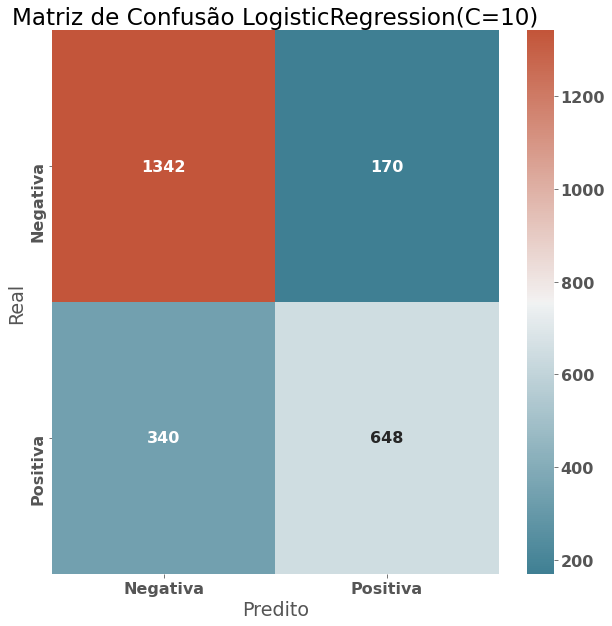

In [468]:
p = matriz_de_confusao(y_test, y_pred_svm, 'LogisticRegression(C=10)')

# FIM

![](https://media2.giphy.com/media/xULW8v7LtZrgcaGvC0/200w.webp?cid=ecf05e4738k0vbjazr5gey0pewfedulp9nkwixnizuxtrabr&rid=200w.webp&ct=g)